# Large Scale Data Science (CC3047) - 2024/2025

## Machine Learning Pipeline - Is solving this problem an actual challenge?

Work by Alexandre Sousa (2022206427) and Francisco Carqueija (202205113)

---

The project focuses on building a Machine Learning pipeline that aims to perform large-scale data analysis on patient events in the ICU. The main focuses of this work are:

-> Statistical analysis and visualization of data by patient (SUBJECT_ID)

-> Prediction of length of stay in the ICU with machine learning models.

-> Use appropriate tools to efficiently process large volumes of data (PySpark, MapReduce, BigQuery, etc.).

-> Evaluate and discuss performance issues (execution time, profile).

For this project we need to take into consideration the choices for our preprocessing, the choices for our data preparation, our choices on how to train and validate our models and the quality of the analysis, interpretations and discussion of results

---

# Table of contents

<!-- Hello World -->
1. [Libraries Needed](#Libraries-Needed)
2. [Introduction](#Introduction)
3. [Analysis of part of the MIMIC-III Database](#Analysis-of-part-of-the-MIMIC-III-Database)
    - [ADMISSIONS](#ADMISSIONS)
    - [CHARTEVENTS](#CHARTEVENTS)
    - [D_ITEMS](#D_ITEMS)
    - [DIAGNOSES_ICD](#DIAGNOSES_ICD)
    - [D_ICD_DIAGNOSES](#D_ICD_DIAGNOSES)
    - [ICUSTAYS](#ICUSTAYS)
    - [PATIENTS](#PATIENTS)
    - [PROCEDURES_ICD](#PROCEDURES_ICD)
    - [D_ICD_PROCEDURES](#D_ICD_PROCEDURES)
4. [Obtain the top 5 diseases with more occurencies](#Obtain-the-top-5-diseases-with-more-occurencies)
5. [Merge of the different tables](#Merge-of-the-different-tables)
6. [Exploratory Data Analysis of the Data (raw_features)](#Exploratory-Data-Analysis-of-the-Data-(raw_features))
    - [General Analysis](#General-Analysis)
    - [Specific Analysis](#Specific-Analysis)
        - [Patients Analysis](#Patients-Analysis)
        - [Hospital Admissions Analysis](#Hospital-Admissions-Analysis)


---

# Libraries Needed 

In [1]:
!python -V

Python 3.11.11


#### Standard Libraries

In [1]:
import os
import math
import time
import re
from datetime import datetime

### Google Cloud / BigQuery

In [2]:
from google.cloud import bigquery
import pandas_gbq
import bigframes as bf
import bigframes.pandas as bpd
from bigframes.ml.model_selection import train_test_split as bf_train_test_split
from bigframes.ml.linear_model import LinearRegression as BFLinearRegression
from bigframes.ml.ensemble import RandomForestRegressor as BFRandomForestRegressor
from bigframes.ml.metrics import r2_score as bf_r2_score, mean_squared_error as bf_mse

### Pandas / Dask / NumPy

In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

### Scikit-Learn

In [4]:
from sklearn.model_selection import train_test_split as sk_train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.metrics import mean_squared_error as sk_mse

### PySpark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, isnan, mean as count, when, udf, regexp_replace, coalesce, lit
)
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression as SparkLinearRegression, RandomForestRegressor as SparkRandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

### Plotting

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### Set credentials and initialize clients

In [7]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ml-pipeline-459822-e0958fb6a5e7.json"
client = bigquery.Client()

---

# Introduction
[[ go back to the top ]](#Table-of-contents)




### NEED TO CHANGE !!!!!!!!!

The dataset we are analysing is CHARTEVENTS.csv.gz from the MIMIC-III clinical database. 
It contains detailed time-stamped measurements and observations recorded in the ICU, including vital signs (e.g., heart rate, blood pressure, temperature), lab test results, and other patient-specific metrics. Each row corresponds to a single charted event and includes key fields such as SUBJECT_ID (patient identifier), HADM_ID (hospital admission ID), ICUSTAY_ID (ICU stay ID), ITEMID (type of measurement), CHARTTIME (timestamp), and VALUE (the observed or recorded value). The dataset is large and granular, enabling detailed temporal analysis of patient states during ICU stays, which is essential for tasks like predicting length of stay, assessing patient deterioration, and analyzing treatment outcomes.

### -Why we use bigframes.pandas and not other tools

We use bigframes.pandas because it lets us work with massive BigQuery datasets using familiar pandas-like syntax, without downloading the data. All operations run in BigQuery, making it scalable and memory-efficient — ideal for analyzing MIMIC’s large medical tables.

##### Why Not Other Tools
- pandas: Loads all data into memory — crashes with large datasets.
- cuDF: Needs a local GPU, not suited for cloud SQL queries.
- Dask/Polars: Good for local or distributed CSVs, but don’t integrate easily with BigQuery.

---

# Analysis of part of the MIMIC-III Database
[[ go back to the top ]](#Table-of-contents)

Firstly, we get the data from the MIMIC-III database, which is a large dataset containing information about patients in the ICU. The dataset is stored in BigQuery and we use the bigframes.pandas library to access it.

We then proceed to analyze the different tables to get a general understanding of the data we are working with and the relationships between the different tables. 

The tables we chose to analyze are:
- ADMISSIONS
- CHARTEVENTS
- D_ITEMS
- DIAGNOSES_ICD
- D_ICD_DIAGNOSES
- ICUSTAYS
- PATIENTS
- PROCEDURES_ICD
- D_ICD_PROCEDURES  


---

## ADMISSIONS

In [21]:
df_admissions = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.admissions`", use_cache=False)

In [24]:
df_admissions.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 58976 entries, 0 to 58975
Data columns (total 19 columns):
  #  Column                Non-Null Count    Dtype
---  --------------------  ----------------  ------------------------------
  0  ROW_ID                58976 non-null    Int64
  1  SUBJECT_ID            58976 non-null    Int64
  2  HADM_ID               58976 non-null    Int64
  3  ADMITTIME             58976 non-null    timestamp[us, tz=UTC][pyarrow]
  4  DISCHTIME             58976 non-null    timestamp[us, tz=UTC][pyarrow]
  5  DEATHTIME             5854 non-null     timestamp[us, tz=UTC][pyarrow]
  6  ADMISSION_TYPE        58976 non-null    string
  7  ADMISSION_LOCATION    58976 non-null    string
  8  DISCHARGE_LOCATION    58976 non-null    string
  9  INSURANCE             58976 non-null    string
 10  LANGUAGE              33644 non-null    string
 11  RELIGION              58518 non-null    string
 12  MARITAL_STATUS        48848 non-null    string
 13  ETHNICITY        

In [22]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,14629,11898,108389,2128-01-13 20:55:00+00:00,2128-01-15 18:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,DISCH-TRAN TO PSYCH HOSP,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2128-01-13 18:08:00+00:00,2128-01-13 22:36:00+00:00,OVERDOSE,0,1
1,14339,11705,165730,2165-11-18 13:40:00+00:00,2165-11-27 17:30:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,<NA>,NOT SPECIFIED,<NA>,OTHER,<NA>,<NA>,NEWBORN,0,1
2,57944,96731,198001,2124-09-11 17:37:00+00:00,2124-09-13 14:38:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2124-09-11 09:32:00+00:00,2124-09-11 19:17:00+00:00,ASTHMA;CHRONIC OBST PULM DISEASE,0,1
3,55611,89600,108570,2106-03-17 11:44:00+00:00,2106-03-20 12:50:00+00:00,2106-03-20 12:50:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2106-03-17 10:01:00+00:00,2106-03-17 14:19:00+00:00,ACUTE SUBDURAL HEMATOMA,1,1
4,31247,25553,164133,2146-05-30 20:47:00+00:00,2146-06-22 23:59:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,2146-05-30 19:02:00+00:00,2146-05-30 21:35:00+00:00,COPD EXACERBATION,0,1


---

## CHARTEVENTS


In [13]:
df_chartevents = bpd.read_gbq("ml-pipeline-459822.data.chartevents", use_cache=False)

In [14]:
df_chartevents.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 330712483 entries, 0 to 330712482
Data columns (total 15 columns):
  #  Column        Dtype
---  ------------  ----------------------
  0  ROW_ID        Int64
  1  SUBJECT_ID    Int64
  2  HADM_ID       Int64
  3  ICUSTAY_ID    Int64
  4  ITEMID        Int64
  5  CHARTTIME     timestamp[us][pyarrow]
  6  STORETIME     timestamp[us][pyarrow]
  7  CGID          Int64
  8  VALUE         string
  9  VALUENUM      Float64
 10  VALUEUOM      string
 11  WARNING       Int64
 12  ERROR         Int64
 13  RESULTSTATUS  string
 14  STOPPED       string
dtypes: Float64(1), Int64(8), string(4), timestamp[us][pyarrow](2)
memory usage: 42331197824 bytes


In [106]:
df_chartevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,227480130,1663,162078,295174,8551,2141-04-06 07:50:00,2141-04-06 07:52:00,15004,160,160.0,mmHg,<NA>,<NA>,<NA>,NotStopd
1,35461753,234,134944,233735,776,2106-04-10 12:38:00,2106-04-10 12:42:00,15331,-3,-3.0,<NA>,<NA>,<NA>,Final,NotStopd
2,36434629,423,194013,248770,1484,2169-07-07 02:30:00,2169-07-07 04:25:00,18524,Yes,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,213123811,19361,128434,276021,392,2177-02-03 04:00:00,2177-02-03 04:19:00,17704,Serous,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
4,145067178,21838,143088,200378,3446,2136-08-14 08:00:00,2136-08-14 08:12:00,19371,33-36 weeks gest,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd


We decided to remove  the following columns from the table because they don’t add useful information for predicting the length of stay in the ICU:

 - STORETIME => This just tells us when the data was manually entered or confirmed, which isn’t important for our goal.
 - CGID – Identifies who entered or validated the data, but that’s not relevant for predicting how long a patient stays.


In [33]:
df_chartevents = df_chartevents.drop(columns=["STORETIME", "CGID"])

---

## D_ITEMS



In [15]:
df_d_items = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_items`", use_cache=False)

In [16]:
df_d_items.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 12487 entries, 0 to 12486
Data columns (total 10 columns):
  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  -------
  0  ROW_ID        12487 non-null    Int64
  1  ITEMID        12487 non-null    Int64
  2  LABEL         12484 non-null    string
  3  ABBREVIATION  2992 non-null     string
  4  DBSOURCE      12487 non-null    string
  5  LINKSTO       12487 non-null    string
  6  CATEGORY      6049 non-null     string
  7  UNITNAME      1234 non-null     string
  8  PARAM_TYPE    2992 non-null     string
  9  CONCEPTID     0 non-null        string
dtypes: Int64(2), string(8)
memory usage: 1098856 bytes


In [17]:
df_d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,3325,1996,HIGH MIN. VOL.,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
1,4423,6898,TRACHEA DSG,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,12841,223921,Neuro Symptoms,Neuro Symptoms,metavision,chartevents,Neurological,<NA>,Text,<NA>
3,1655,4813,nutrition labs,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
4,556,599,RUL Lung Sounds,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>


---

## DIAGNOSES_ICD



In [18]:
df_diagnoses_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.diagnoses_icd`", use_cache=False)

In [38]:
df_diagnoses_icd.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 651047 entries, 0 to 651046
Data columns (total 5 columns):
  #  Column      Dtype
---  ----------  -------
  0  ROW_ID      Int64
  1  SUBJECT_ID  Int64
  2  HADM_ID     Int64
  3  SEQ_NUM     Int64
  4  ICD9_CODE   string
dtypes: Int64(4), string(1)
memory usage: 31250256 bytes


In [113]:
df_diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,328395,28879,163707,5,4019
1,607827,90609,146682,1,0380
2,577044,83314,108439,2,5070
3,564547,80752,180665,21,42789
4,591003,86662,140257,19,2724


---

## D_ICD_DIAGNOSES


In [19]:
df_d_icd_diagnoses = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_diagnoses`", use_cache=False)

In [40]:
df_d_icd_diagnoses.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 14567 entries, 0 to 14566
Data columns (total 4 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  -------
  0  ROW_ID       14567 non-null    Int64
  1  ICD9_CODE    14567 non-null    string
  2  SHORT_TITLE  14567 non-null    string
  3  LONG_TITLE   14567 non-null    string
dtypes: Int64(1), string(3)
memory usage: 582680 bytes


In [116]:
df_d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,14184,E9839,Undet circ-suffocate NOS,Strangulation or suffocation by unspecified me...
1,11678,E9258,Electric current acc NEC,Accident caused by other electric current
2,8999,7810,Abn involun movement NEC,Abnormal involuntary movements
3,7735,6959,Erythematous cond NOS,Unspecified erythematous condition
4,399,0913,Secondary syph skin,Secondary syphilis of skin or mucous membranes


---

## ICUSTAYS


In [26]:
df_icustays = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.icustays`", use_cache=False)

In [42]:
df_icustays.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 61532 entries, 0 to 61531
Data columns (total 12 columns):
  #  Column          Non-Null Count    Dtype
---  --------------  ----------------  ------------------------------
  0  ROW_ID          61532 non-null    Int64
  1  SUBJECT_ID      61532 non-null    Int64
  2  HADM_ID         61532 non-null    Int64
  3  ICUSTAY_ID      61532 non-null    Int64
  4  DBSOURCE        61532 non-null    string
  5  FIRST_CAREUNIT  61532 non-null    string
  6  LAST_CAREUNIT   61532 non-null    string
  7  FIRST_WARDID    61532 non-null    Int64
  8  LAST_WARDID     61532 non-null    Int64
  9  INTIME          61532 non-null    timestamp[us, tz=UTC][pyarrow]
 10  OUTTIME         61522 non-null    timestamp[us, tz=UTC][pyarrow]
 11  LOS             61522 non-null    Float64
dtypes: Float64(1), Int64(6), string(3), timestamp[us, tz=UTC][pyarrow](2)
memory usage: 6399328 bytes


In [119]:
df_icustays.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,53549,76114,127379,238616,metavision,TSICU,TSICU,14,14,2194-04-28 18:25:13+00:00,2194-04-29 16:01:00+00:00,0.8998
1,53711,76502,197100,298669,metavision,TSICU,TSICU,14,14,2142-11-04 10:29:02+00:00,2142-11-05 13:43:13+00:00,1.1348
2,36549,28843,194297,234364,carevue,TSICU,TSICU,14,14,2156-07-30 20:16:36+00:00,2156-07-31 19:48:40+00:00,0.9806
3,19054,15021,102989,278373,carevue,CSRU,CSRU,14,14,2181-04-05 11:08:06+00:00,2181-04-06 22:46:33+00:00,1.485
4,26492,20892,182895,210457,carevue,NICU,NICU,56,56,2143-05-29 18:41:52+00:00,2143-05-30 13:29:11+00:00,0.7829


---

## PATIENTS

In [43]:
df_patients = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.patients`", use_cache=False)

In [44]:
df_patients.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 46520 entries, 0 to 46519
Data columns (total 8 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  ------------------------------
  0  ROW_ID       46520 non-null    Int64
  1  SUBJECT_ID   46520 non-null    Int64
  2  GENDER       46520 non-null    string
  3  DOB          46520 non-null    timestamp[us, tz=UTC][pyarrow]
  4  DOD          15759 non-null    timestamp[us, tz=UTC][pyarrow]
  5  DOD_HOSP     9974 non-null     timestamp[us, tz=UTC][pyarrow]
  6  DOD_SSN      13378 non-null    timestamp[us, tz=UTC][pyarrow]
  7  EXPIRE_FLAG  46520 non-null    Int64
dtypes: Int64(3), string(1), timestamp[us, tz=UTC][pyarrow](4)
memory usage: 3349440 bytes


In [122]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33888,51786,F,2090-04-16 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,23653,25061,M,2114-07-11 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,1
2,44113,90788,M,2094-04-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
3,3452,3652,F,2042-07-26 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,1
4,10760,11381,M,2143-04-22 00:00:00+00:00,<NA>,<NA>,<NA>,0


---

## PROCEDURES_ICD


In [45]:
df_procedures_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.procedures_icd`", use_cache=False)

In [46]:
df_procedures_icd.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 240095 entries, 0 to 240094
Data columns (total 5 columns):
  #  Column      Dtype
---  ----------  -------
  0  ROW_ID      Int64
  1  SUBJECT_ID  Int64
  2  HADM_ID     Int64
  3  SEQ_NUM     Int64
  4  ICD9_CODE   Int64
dtypes: Int64(5)
memory usage: 11524560 bytes


In [125]:
df_procedures_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,66403,25809,117092,5,9604
1,13101,2237,142708,2,3606
2,23025,1563,183430,4,9672
3,198865,53463,183511,7,9711
4,201551,99544,145236,15,7966


---

## D_ICD_PROCEDURES

In [47]:
df_d_icd_procedures = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_procedures`", use_cache=False)

In [48]:
df_d_icd_procedures.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 3882 entries, 0 to 3881
Data columns (total 4 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  -------
  0  ROW_ID       3882 non-null     Int64
  1  ICD9_CODE    3882 non-null     Int64
  2  SHORT_TITLE  3882 non-null     string
  3  LONG_TITLE   3882 non-null     string
dtypes: Int64(2), string(2)
memory usage: 155280 bytes


In [128]:
df_d_icd_procedures.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1100,2169,Turbinectomy NEC,Other turbinectomy
1,796,3887,Occlude abd vein NEC,"Other surgical occlusion of vessels, abdominal..."
2,2056,8423,Forearm/wrist/hand reatt,"Forearm, wrist, or hand reattachment"
3,723,3857,Abd varicos v liga-strip,"Ligation and stripping of varicose veins, abdo..."
4,3178,9461,Alcohol rehabilitation,Alcohol rehabilitation


---

# Obtain the top 5 diseases with more occurencies

[[ go back to the top ]](#Table-of-contents)

In this section, we will obtain the top 5 diseases with more occurrences in the MIMIC-III database. We will use the DIAGNOSES_ICD and D_ICD_DIAGNOSES tables to get the information we need.

In [20]:
# Step 1: Get top 3 ICD9 codes by frequency
top_5_codes = df_diagnoses_icd['ICD9_CODE'].value_counts().head(5).index

print("Top 5 most common disease codes:")
# Step 2: Loop through the top codes and retrieve their SHORT_TITLE
for code in top_5_codes:
    # Filter for the corresponding row in d_icd_diagnoses
    filtered_row = df_d_icd_diagnoses[df_d_icd_diagnoses['ICD9_CODE'] == code]
    
    if not filtered_row.empty:
        short_title = filtered_row['SHORT_TITLE'].values[0]
        count = df_diagnoses_icd['ICD9_CODE'].value_counts()[code]
        print(f"{short_title} ({code}) — {count} occurrences")
    else:
        print(f"ICD9 code {code} not found in the descriptions table.")

Top 5 most common disease codes:
Hypertension NOS (4019) — 20703 occurrences
CHF NOS (4280) — 13111 occurrences
Atrial fibrillation (42731) — 12891 occurrences
Crnry athrscl natve vssl (41401) — 12429 occurrences
Acute kidney failure NOS (5849) — 9119 occurrences


# Merge of the different tables

[[ go back to the top ]](#Table-of-contents)

In this part, we get the data we’re going to use. We start by selecting useful information from several tables, like patient details, ICU stay info, and vital sign measurements.

We then save that full dataset into a BigQuery table called all_features.

After that, we add diagnosis information by joining with another table that has ICD9 disease codes. We only keep rows related to the 5 most common diagnoses in our data. This cleaned and filtered version is saved in a new table called raw_features, which we’ll use for the machine learning part.

In [9]:
query = """
SELECT DISTINCT
  chartevents.SUBJECT_ID,
  chartevents.HADM_ID,
  chartevents.ICUSTAY_ID,
  chartevents.CHARTTIME,
  chartevents.VALUEUOM,
  patients.DOB,
  admissions.ADMITTIME,
  admissions.DISCHTIME,
  admissions.DEATHTIME,
  admissions.HOSPITAL_EXPIRE_FLAG,
  admissions.ADMISSION_TYPE,
  patients.GENDER,
  admissions.ETHNICITY,
  admissions.RELIGION,
  admissions.LANGUAGE,
  admissions.MARITAL_STATUS,
  admissions.INSURANCE,
  chartevents.ITEMID,
  d_items.LABEL,
  d_items.CATEGORY,
  chartevents.VALUE,
  chartevents.VALUENUM,
  chartevents.WARNING,
  chartevents.ERROR,
  icustays.INTIME,
  icustays.LOS
FROM
  `ml-pipeline-459822.data.chartevents` AS chartevents
LEFT JOIN
  `ml-pipeline-459822.data.patients` AS patients
  ON chartevents.SUBJECT_ID = patients.SUBJECT_ID
LEFT JOIN
  `ml-pipeline-459822.data.d_items` AS d_items
  ON chartevents.ITEMID = d_items.ITEMID
LEFT JOIN
  `ml-pipeline-459822.data.admissions` AS admissions
  ON chartevents.HADM_ID = admissions.HADM_ID
LEFT JOIN
  `ml-pipeline-459822.data.icustays` AS icustays
  ON chartevents.ICUSTAY_ID = icustays.ICUSTAY_ID
"""
# Executing the SQL query and storing the results in the 'all_features' dataframe
all_features = bpd.read_gbq(query, use_cache=False)

# Displaying the resulting dataframe
all_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,...,INSURANCE,ITEMID,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS
0,69630,173873,270282,2148-08-31 04:29:00,<NA>,1848-08-31 00:00:00+00:00,2148-08-31 04:08:00+00:00,2148-09-02 02:30:00+00:00,2148-09-02 02:30:00+00:00,1,...,Medicare,224072,Education Learner,Restraint/Support Systems,Significant Other/Family,<NA>,0,0,2148-08-31 04:10:27+00:00,1.9756
1,21981,142257,218183,2102-03-14 11:00:00,<NA>,1802-03-03 00:00:00+00:00,2102-03-03 07:05:00+00:00,2102-03-14 12:00:00+00:00,2102-03-14 12:00:00+00:00,1,...,Medicare,617,Respiratory Pattern,<NA>,Regular,<NA>,<NA>,<NA>,2102-03-03 07:06:34+00:00,11.7225
2,13415,189790,230701,2108-09-21 07:00:00,<NA>,2108-08-16 00:00:00+00:00,2108-08-16 18:03:00+00:00,2108-10-08 12:00:00+00:00,<NA>,0,...,Private,3429,Feeding Tube Size,<NA>,5,5.0,<NA>,<NA>,2108-08-16 18:24:23+00:00,52.8522
3,15057,102540,227356,2123-03-04 20:00:00,<NA>,2064-03-13 00:00:00+00:00,2123-02-22 07:02:00+00:00,2123-03-13 13:05:00+00:00,<NA>,0,...,Private,663,Support Systems,<NA>,Spouse,<NA>,<NA>,<NA>,2123-03-03 08:05:48+00:00,6.1916
4,83749,122354,206253,2102-02-21 20:18:00,<NA>,2033-04-08 00:00:00+00:00,2102-02-16 18:05:00+00:00,2102-04-14 13:08:00+00:00,2102-04-14 13:08:00+00:00,1,...,Medicare,224055,Braden Moisture,Skin - Assessment,Occasionally Moist,3.0,0,0,2102-02-16 18:05:21+00:00,50.0966


In [10]:
# Writing the 'all_features' dataframe to the 'cdl-pratica.Data.all_features' table in Google BigQuery, replacing it if it already exists
all_features.to_gbq('ml-pipeline-459822.data.all_features', if_exists='replace')

'ml-pipeline-459822.data.all_features'

In [11]:
# SQL query to select all features from the 'all_features' table and additional diagnosis-related columns from the 'df_diagnoses' table,
# joining them on the 'SUBJECT_ID' column and filtering rows where the 'ICD9_CODE' column equals '4019'
query2 = """
SELECT DISTINCT
  af.*,
  d.ICD9_CODE,
  d.SEQ_NUM
FROM
  `ml-pipeline-459822.data.all_features` AS af
LEFT JOIN
  `ml-pipeline-459822.data.diagnoses_icd` AS d
ON
  af.SUBJECT_ID = d.SUBJECT_ID AND af.HADM_ID = d.HADM_ID
WHERE
  d.ICD9_CODE IN ('4019', '42731', '4280', '41401', '5849')
"""

# Executing the SQL query and storing the results in the 'raw_features' dataframe
raw_features = bpd.read_gbq(query2, use_cache=False)



# Displaying the resulting dataframe
raw_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,...,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
0,22076,154613,205674,2160-11-22 01:00:00,%,2079-11-28 00:00:00+00:00,2160-11-15 16:25:00+00:00,2160-11-28 16:15:00+00:00,<NA>,0,...,SpO2 Alarm [High],<NA>,100,100.0,<NA>,<NA>,2160-11-21 11:05:48+00:00,2.3177,4019,10
1,11765,196798,244301,2167-05-15 03:00:00,<NA>,2114-01-22 00:00:00+00:00,2167-04-28 22:55:00+00:00,2167-07-02 11:45:00+00:00,<NA>,0,...,Ectopy Type,<NA>,None,<NA>,<NA>,<NA>,2167-04-28 22:56:33+00:00,24.7562,41401,14
2,46156,127108,258962,2134-08-31 21:16:00,insp/min,2053-06-04 00:00:00+00:00,2134-08-16 16:37:00+00:00,2134-09-07 16:47:00+00:00,<NA>,0,...,Respiratory Rate (spontaneous),Respiratory,0,0.0,0,0,2134-08-16 16:38:08+00:00,19.0972,4280,18
3,80454,147903,247883,2175-06-07 12:00:00,<NA>,2105-06-04 00:00:00+00:00,2175-06-06 11:30:00+00:00,2175-06-16 14:00:00+00:00,<NA>,0,...,Dorsal PedPulse L,Cardiovascular (Pulses),Easily Palpable,<NA>,0,0,2175-06-06 10:04:35+00:00,1.2221,4019,8
4,6024,104644,254201,2125-01-02 12:00:00,kg,2057-07-06 00:00:00+00:00,2124-12-31 20:35:00+00:00,2125-01-03 16:30:00+00:00,<NA>,0,...,Previous WeightF,<NA>,66.199996948242188,66.199997,<NA>,<NA>,2124-12-31 20:36:08+00:00,1.7858,4019,1


In [12]:
# Writing the 'raw_features' dataframe to the 'cdl-pratica.Data.raw_features' table in Google BigQuery, replacing it if it already exists
raw_features.to_gbq('ml-pipeline-459822.data.raw_features', if_exists='replace')     

'ml-pipeline-459822.data.raw_features'

------

# Exploratory Data Analysis of the Data (raw_features)
[[ go back to the top ]](#Table-of-contents)

For the exploratory data analysis, we will use the raw_features table that we created in the previous section, so from here on out we will be analysing always the information of the top 5 diseases with more occurrences in the MIMIC-III database.

We will divide the analysis into two parts:
1. **General Analysis**: We will analyze the data in general, without focusing on any specific topic
2. **Specific Analysis**: We will analyze the data focusing on specific information about the patients and the hospital admissions

This way we can get a general understanding of the data and then focus on specific topics that are more relevant to our goal of predicting the length of stay in the ICU. 

In [35]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery into a pandas DataFrame
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

In [8]:
raw_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,...,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,OUTTIME,LOS,ICD9_CODE,SEQ_NUM
0,32670,187678,255943,2164-05-23 11:00:00,2083-03-02 00:00:00+00:00,2164-05-17 20:34:00+00:00,2164-05-24 10:50:00+00:00,<NA>,0,EMERGENCY,...,<NA>,On Guideline,<NA>,<NA>,<NA>,2164-05-18 15:06:43+00:00,2164-05-24 10:59:53+00:00,5.8286,5849,3
1,4644,148758,223853,2133-03-26 22:00:00,2062-06-29 00:00:00+00:00,2133-03-24 01:37:00+00:00,2133-03-31 12:15:00+00:00,<NA>,0,EMERGENCY,...,<NA>,1,1.0,<NA>,<NA>,2133-03-24 01:37:55+00:00,2133-03-31 12:51:50+00:00,7.468,42731,6
2,12379,124566,238302,2186-08-03 21:00:00,2121-11-28 00:00:00+00:00,2186-08-03 07:15:00+00:00,2186-08-07 17:25:00+00:00,<NA>,0,ELECTIVE,...,<NA>,None,<NA>,<NA>,<NA>,2186-08-03 09:55:42+00:00,2186-08-04 18:03:21+00:00,1.3386,4019,5
3,84378,124808,271862,2179-11-25 02:00:00,2119-09-21 00:00:00+00:00,2179-11-17 02:14:00+00:00,2179-12-07 17:00:00+00:00,<NA>,0,EMERGENCY,...,Routine Vital Signs,None,<NA>,0,0,2179-11-17 02:15:24+00:00,2179-12-06 15:07:18+00:00,19.536,42731,15
4,19568,102532,230624,2124-11-06 06:00:00,2066-11-06 00:00:00+00:00,2124-11-04 16:42:00+00:00,2124-11-07 01:12:00+00:00,2124-11-07 01:12:00+00:00,1,EMERGENCY,...,<NA>,8,8.0,<NA>,<NA>,2124-11-05 14:47:55+00:00,2124-11-07 04:42:41+00:00,1.5797,5849,2


## **General Analysis**
[[ go back to the top ]](#Table-of-contents)

In this section, we will analyze the data in general, without focusing on any specific topic.
The analysis that take part in this section are as follows:
- **Number of rows and columns**: We will check how many rows and columns we have in the dataset.
- **Data types**: We will check the data types of the columns in the dataset.
- **Missing values**: We will check if there are any missing values in the dataset.
- **Distrbution of the length of stay**: We will check the distribution of the length of stay in the ICU.
- **Distribution of Hospital Duration**: We will check the distribution of the length of stay in the ICU by hospital.
- **Most common clinical measurements**: We will check the most common clinical measurements in the dataset.
- **Example of time curve of a patient**: We will check the time curve of a patient to see how the clinical measurements change over time.

### Number of rows and columns

In [18]:
raw_features.shape

(406235959, 28)

### Information about the number of entries, columns, and data types

In [16]:
raw_features.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 406235959 entries, 0 to 406235958
Data columns (total 28 columns):
  #  Column                Dtype
---  --------------------  ------------------------------
  0  SUBJECT_ID            Int64
  1  HADM_ID               Int64
  2  ICUSTAY_ID            Int64
  3  CHARTTIME             timestamp[us][pyarrow]
  4  VALUEUOM              string
  5  DOB                   timestamp[us, tz=UTC][pyarrow]
  6  ADMITTIME             timestamp[us, tz=UTC][pyarrow]
  7  DISCHTIME             timestamp[us, tz=UTC][pyarrow]
  8  DEATHTIME             timestamp[us, tz=UTC][pyarrow]
  9  HOSPITAL_EXPIRE_FLAG  Int64
 10  ADMISSION_TYPE        string
 11  GENDER                string
 12  ETHNICITY             string
 13  RELIGION              string
 14  LANGUAGE              string
 15  MARITAL_STATUS        string
 16  INSURANCE             string
 17  ITEMID                Int64
 18  LABEL                 string
 19  CATEGORY              string
 20  VAL

### Checking for missing values

In [15]:
raw_features.isnull().sum()

SUBJECT_ID                      0
HADM_ID                         0
ICUSTAY_ID                 261508
CHARTTIME                       0
VALUEUOM                263805454
DOB                             0
ADMITTIME                       0
DISCHTIME                       0
DEATHTIME               322990383
HOSPITAL_EXPIRE_FLAG            0
ADMISSION_TYPE                  0
GENDER                          0
ETHNICITY                       0
RELIGION                  2693777
LANGUAGE                147914602
MARITAL_STATUS           18661087
INSURANCE                       0
ITEMID                          0
LABEL                           0
CATEGORY                231786777
VALUE                     2526502
VALUENUM                223935703
WARNING                 244699816
ERROR                   244699816
INTIME                     261508
dtype: Int64

### Columns with Missing Values (Sorted by %)


/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1851877683.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=missing_df, x="Percent", y="Column", palette="crest")


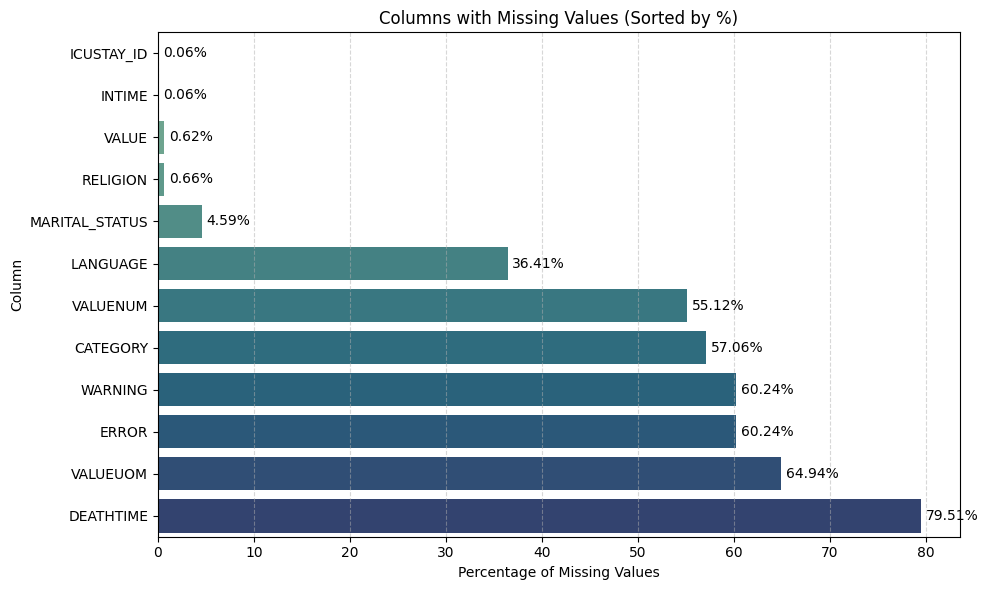

In [ ]:
# Updated total number of rows
total_rows = 406_235_959

# Dictionary of columns and their missing counts
missing_counts = {
    "ICUSTAY_ID": 261_508,
    "VALUEUOM": 263_805_454,
    "DEATHTIME": 322_990_383,
    "RELIGION": 2_693_777,
    "LANGUAGE": 147_914_602,
    "MARITAL_STATUS": 18_661_087,
    "CATEGORY": 231_786_777,
    "VALUE": 2_526_502,
    "VALUENUM": 223_935_703,
    "WARNING": 244_699_816,
    "ERROR": 244_699_816,
    "INTIME": 261_508,
}

# Create DataFrame
missing_df = pd.DataFrame(
    [(col, count, (count / total_rows) * 100) for col, count in missing_counts.items()],
    columns=["Column", "Missing", "Percent"]
)

# Sort and reset index so we can use the row index for positioning
missing_df.sort_values("Percent", inplace=True)
missing_df.reset_index(drop=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=missing_df, x="Percent", y="Column", palette="crest")

# Add percentage labels to the right of each bar
for i, row in missing_df.iterrows():
    ax.text(row["Percent"] + 0.5, i, f"{row['Percent']:.2f}%", va="center")

# Aesthetics
plt.title("Columns with Missing Values (Sorted by %)")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Column")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of ICU Length of Stay (LOS)

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/3027288067.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=los_df, x='los_group', y='total_pacientes', palette='Blues_d')


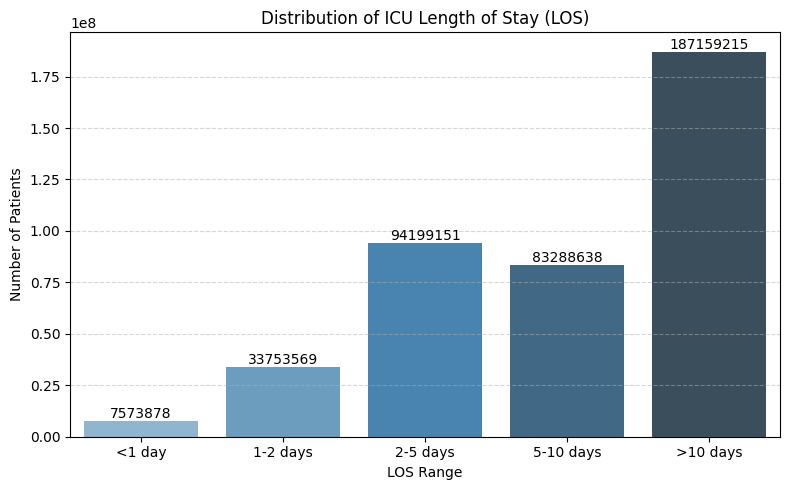

In [ ]:
# # Query to calculate the distribution of ICU Length of Stay (LOS) in days
# query_los = """
# SELECT
#   CASE
#     WHEN LOS < 1 THEN '<1 day'
#     WHEN LOS BETWEEN 1 AND 2 THEN '1-2 days'
#     WHEN LOS BETWEEN 2 AND 5 THEN '2-5 days'
#     WHEN LOS BETWEEN 5 AND 10 THEN '5-10 days'
#     ELSE '>10 days'
#   END AS los_group,
#   COUNT(*) AS total_pacientes
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   LOS IS NOT NULL
# GROUP BY
#   los_group
# """

# los_df = bpd.read_gbq(query_los).to_pandas()

# Define order and sort DataFrame
order = ['<1 day', '1-2 days', '2-5 days', '5-10 days', '>10 days']
los_df['los_group'] = pd.Categorical(los_df['los_group'], categories=order, ordered=True)
los_df = los_df.sort_values('los_group')

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=los_df, x='los_group', y='total_pacientes', palette='Blues_d')

# Add value labels above bars
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 100, f'{int(y)}', ha='center', va='bottom')

# Aesthetics
plt.title("Distribution of ICU Length of Stay (LOS)")
plt.xlabel("LOS Range")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of Hospital Duration

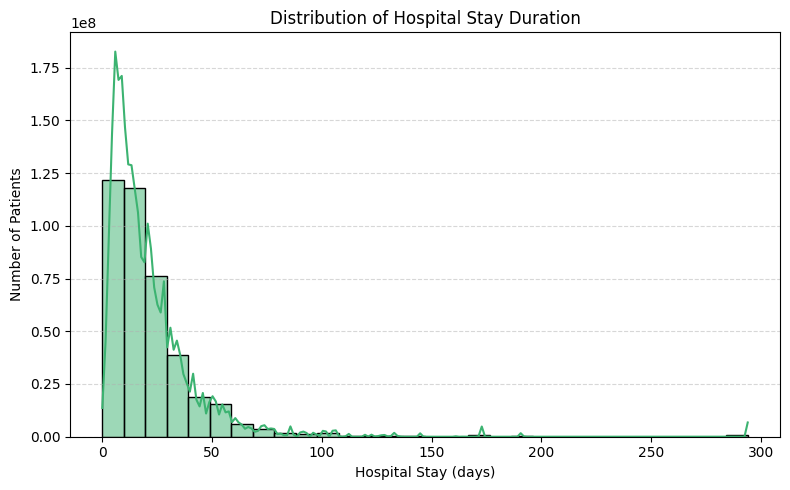

In [14]:
query = """
SELECT
  DATE_DIFF(DISCHTIME, ADMITTIME, DAY) AS hospital_stay_days
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  DISCHTIME IS NOT NULL AND ADMITTIME IS NOT NULL
"""

hospital_stay = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(8, 5))
sns.histplot(hospital_stay['hospital_stay_days'], bins=30, kde=True, color='mediumseagreen')
plt.title("Distribution of Hospital Stay Duration")
plt.xlabel("Hospital Stay (days)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Most commonly recorded clinical measurements in the ICU

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/131455491.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')


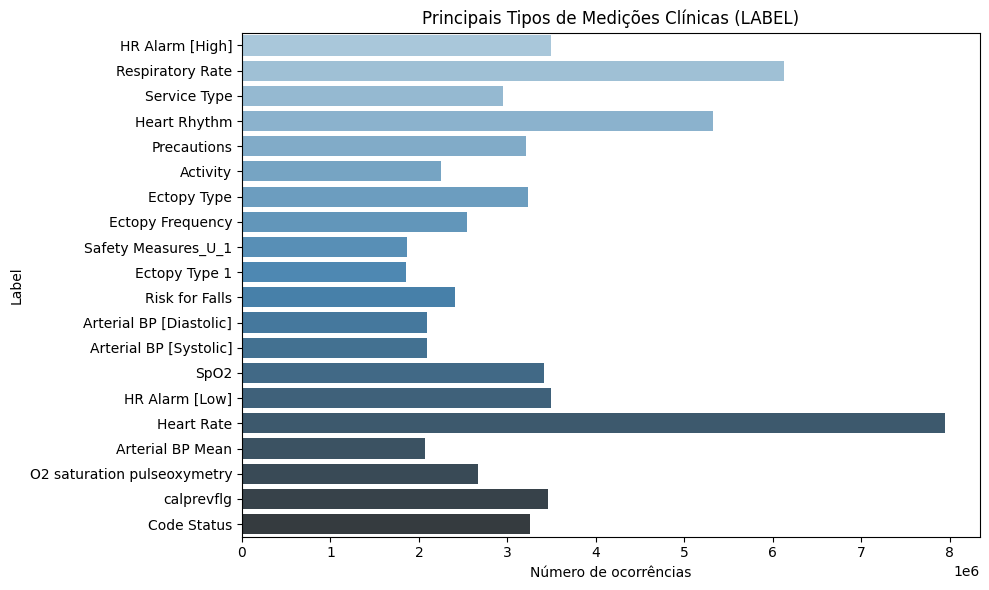

In [ ]:
# query = """
# SELECT
#   di.LABEL,
#   COUNT(*) AS total_ocorrencias
# FROM
#   `ml-pipeline-459822.data.chartevents` AS ce
# JOIN
#   `ml-pipeline-459822.data.d_items` AS di
# ON
#   ce.ITEMID = di.ITEMID
# GROUP BY
#   di.LABEL
# ORDER BY
#   total_ocorrencias DESC
# LIMIT 20
# """

# top_labels = bpd.read_gbq(query).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')
plt.title("Principais Tipos de Medições Clínicas (LABEL)")
plt.xlabel("Número de ocorrências")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

### Example of a time curve of the "Heart Rate", "SpO2", "Respiratory Rate" and "Temperature" metrics for a random patient


 Curvas temporais – Paciente 10006 – Estadia 206504


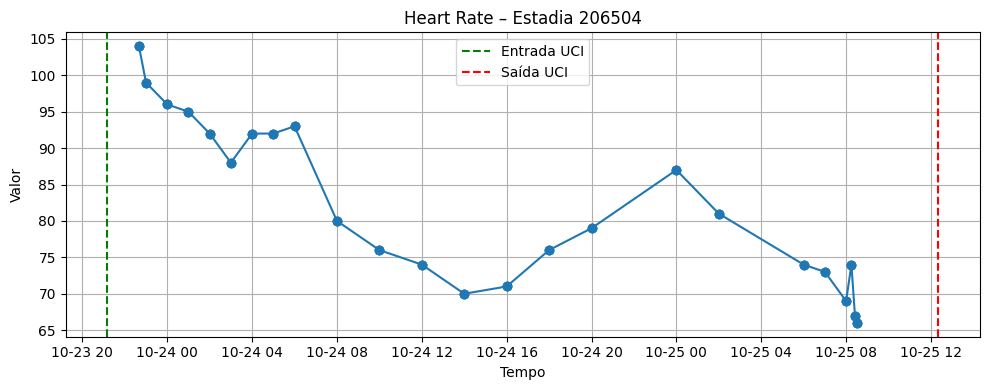

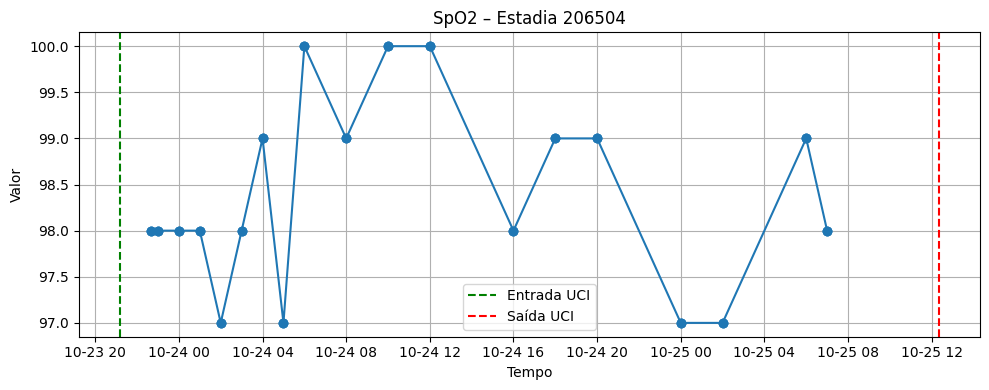

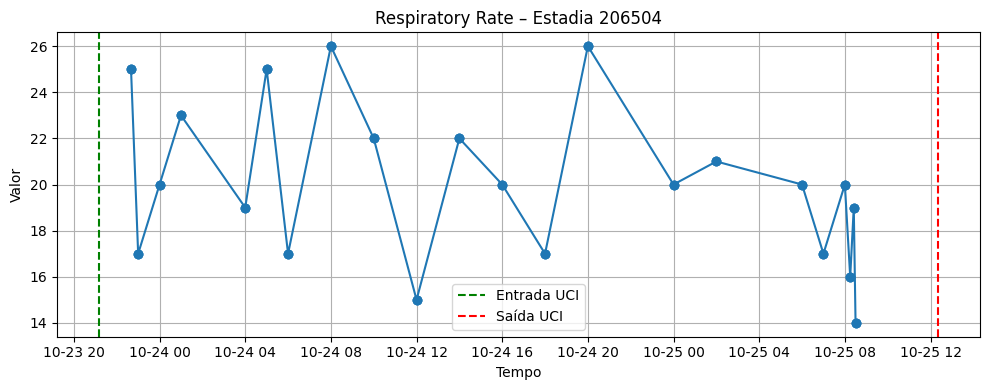

In [ ]:
# query="""
# SELECT
#   rf.CHARTTIME,
#   rf.VALUENUM,
#   rf.LABEL,
#   rf.ICUSTAY_ID
# FROM
#   `ml-pipeline-459822.data.raw_features` AS rf
# WHERE
#   rf.SUBJECT_ID = 10006
#   AND rf.LABEL IN ('Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature')
#   AND rf.VALUENUM IS NOT NULL
# ORDER BY
#   rf.CHARTTIME
# """

# df = bpd.read_gbq(query).to_pandas()

# query="""
# SELECT
#   ICUSTAY_ID,
#   INTIME,
#   OUTTIME
# FROM
#   `ml-pipeline-459822.data.icustays`
# WHERE
#   SUBJECT_ID = 10006
# """
# tempos_uci = bpd.read_gbq(query).to_pandas().set_index('ICUSTAY_ID')



# Lista de métricas a mostrar
metricas = ['Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature']
subject_id = 10006
estadias_uci = df['ICUSTAY_ID'].dropna().unique()

for icu_id in estadias_uci:
    df_icu = df[(df['ICUSTAY_ID'] == icu_id) & (df['LABEL'].isin(metricas))]

    if df_icu.empty or icu_id not in tempos_uci.index:
        continue

    intime = tempos_uci.loc[icu_id, 'INTIME']
    outtime = tempos_uci.loc[icu_id, 'OUTTIME']

    print(f"\n Curvas temporais – Paciente {subject_id} – Estadia {icu_id}")

    for metrica in metricas:
        dados = df_icu[df_icu['LABEL'] == metrica].sort_values('CHARTTIME')

        # Remoção de outliers
        if metrica == 'Respiratory Rate':
            dados = dados[dados['VALUENUM'] < 60]
        if metrica == 'Heart Rate':
            dados = dados[dados['VALUENUM'] < 200]

        if dados.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(dados['CHARTTIME'], dados['VALUENUM'], marker='o', linestyle='-')
        plt.axvline(intime, color='green', linestyle='--', label='Entrada UCI')
        plt.axvline(outtime, color='red', linestyle='--', label='Saída UCI')
        plt.title(f"{metrica} – Estadia {icu_id}")
        plt.xlabel("Tempo")
        plt.ylabel("Valor")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

### One Full Day of Interventions for a Random Patient

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_23221/3447118351.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


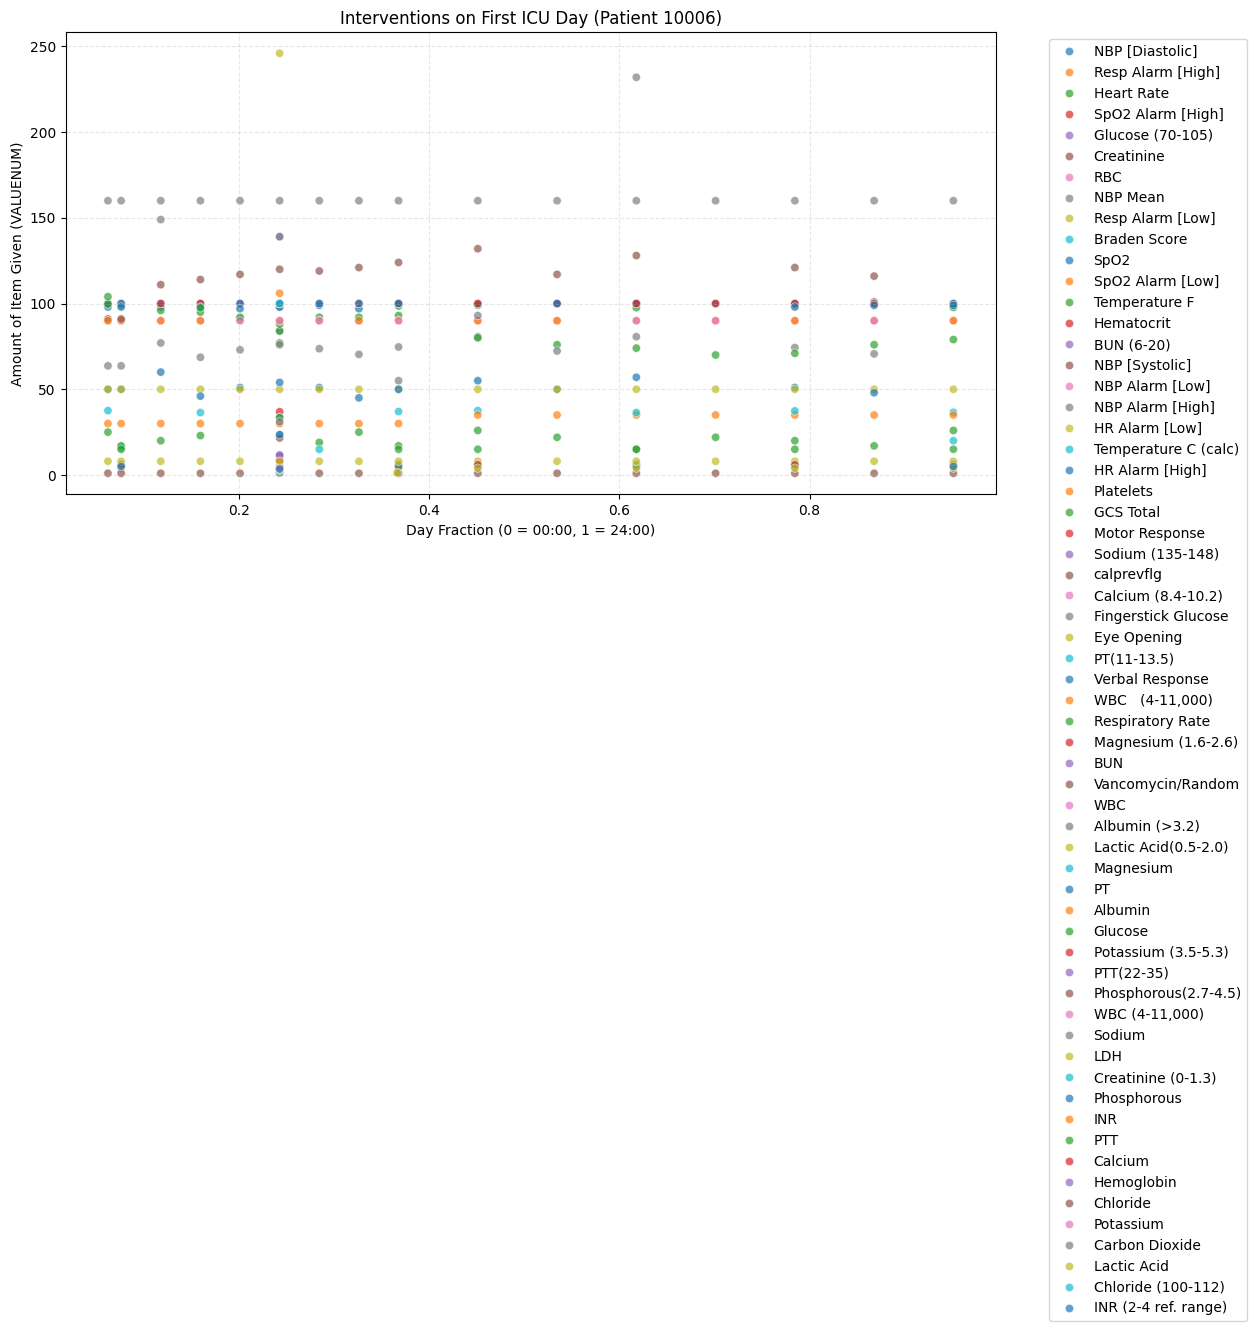

In [33]:
# 1. Query patient interventions over one ICU stay
query = """
SELECT
  ce.ICUSTAY_ID,
  ce.CHARTTIME,
  ce.ITEMID,
  ce.VALUENUM,
  d.LABEL,
  icu.INTIME
FROM
  `ml-pipeline-459822.data.chartevents` AS ce
JOIN
  `ml-pipeline-459822.data.d_items` AS d
  ON ce.ITEMID = d.ITEMID
JOIN
  `ml-pipeline-459822.data.icustays` AS icu
  ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
WHERE
  ce.SUBJECT_ID = 10006
  AND ce.VALUENUM IS NOT NULL
LIMIT 10000
"""

# Run query
patient_data = bpd.read_gbq(query).to_pandas()

# Convert both to timezone-naive
patient_data['CHARTTIME'] = pd.to_datetime(patient_data['CHARTTIME']).dt.tz_localize(None)
patient_data['INTIME'] = pd.to_datetime(patient_data['INTIME']).dt.tz_localize(None)

patient_data['hours_since_start'] = (patient_data['CHARTTIME'] - patient_data['INTIME']).dt.total_seconds() / 3600
patient_data = patient_data[(patient_data['hours_since_start'] >= 0) & (patient_data['hours_since_start'] <= 24)]
patient_data['day_fraction'] = patient_data['hours_since_start'] / 24

# 3. Plot: Dot plot of interventions over the first ICU day
plt.figure(figsize=(12, 6))
sns.scatterplot(data=patient_data, x='day_fraction', y='VALUENUM', hue='LABEL', palette='tab10', legend='full', alpha=0.7)

plt.title("Interventions on First ICU Day (Patient 10006)")
plt.xlabel("Day Fraction (0 = 00:00, 1 = 24:00)")
plt.ylabel("Amount of Item Given (VALUENUM)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

---

## **Specific Analysis**
[[ go back to the top ]](#Table-of-contents)

In this section, we will analyse the data in a more specific way, focusing primarily on the patients and their hospital admissions. The analysis that take part in this section are as follows:

- Patients analysis:
    - **Number of patients**: We will check how many patients are in the dataset.
    - **Disribution of patients by gender**: We will check the distribution of patients based on their gender.
    - **Average length of stay by gender**: We will check the average length of stay in the ICU based on the patients gender. 
    - **Main Diagnoses by gender**: We will check the main diagnoses based on the patients gender.
    - **Distribution of patients by the top 10 ethnicities**: We will check the distribution of patients based on the top 10 ethnicities.
    - **Distribution of patients by marital status**: We will check the distribution of patients based on their marital status.
    - **Distribution of patients by insurance**: We will check the distribution of patients based on their insurance.
    - **Distribution of patients by age**: We will check the distribution of patients based on their age.
    - **Average length of stay by age**: We will check the average length of stay in the ICU based on the patients age.

- Hospital admissions analysis:
    - **Number of Hospital Admissions**: We will check how many hospital admissions are in the dataset.
    - **Number of Patients by Admission Type**: We will check the number of patients based on the type of admission.
    - **Average Length of Stay by Admission Type**: We will check the average length of stay in the ICU based on the type of admission.
    - ***Hospital Admissions over time distribution**: We will check the distribution of hospital admissions over time.
    - **Hospital Mortality Rate by Admission Type**: We will check the hospital mortality rate based on the type of admission.
    - **Survival and Mortality Rate**: We will check the overall survival and mortality rate.





### **Patients Analysis**

### Number of Patients in the Dataset with the 5 most common diseases

In [38]:
raw_features['SUBJECT_ID'].nunique()

np.int64(28472)

### Distribution of Patients by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1921277255.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])  # blue and pink


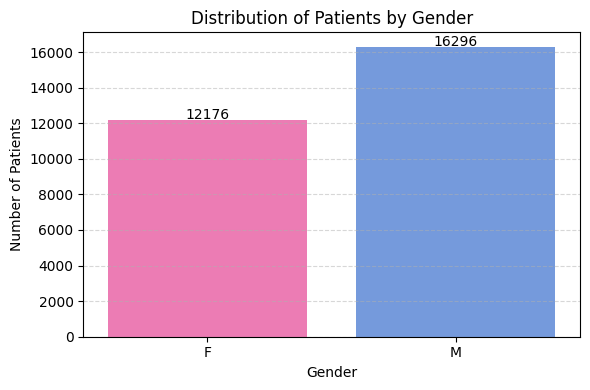

In [ ]:
# query_gender = """
# SELECT
#   GENDER,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   GENDER IS NOT NULL
# GROUP BY
#   GENDER
# ORDER BY
#   num_patients DESC
# """

# # Lê os dados da query
# gender_df = bpd.read_gbq(query_gender).to_pandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])  # blue and pink

# Add counts above bars
for index, row in gender_df.iterrows():
    plt.text(index, row['num_patients'] + 50, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_30558/3529500070.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])


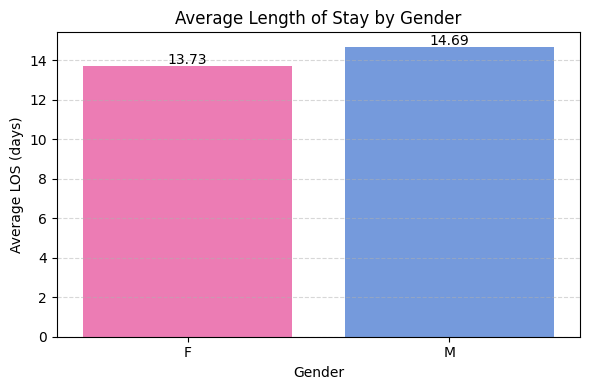

In [21]:
# query_los_gender = """
# SELECT
#   GENDER,
#   AVG(LOS) AS avg_los,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   GENDER IS NOT NULL AND LOS IS NOT NULL
# GROUP BY
#   GENDER
# ORDER BY
#   avg_los DESC
# """


# los_gender_df = bpd.read_gbq(query_los_gender).to_pandas()

# Plot da média de LOS por género
plt.figure(figsize=(6, 4))
sns.barplot(data=los_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])

# Adicionar valores acima das barras
for index, row in los_gender_df.iterrows():
    plt.text(index, row['avg_los'] + 0.1, f"{row['avg_los']:.2f}", ha='center')

plt.title("Average Length of Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Main Diagnosis by Gender

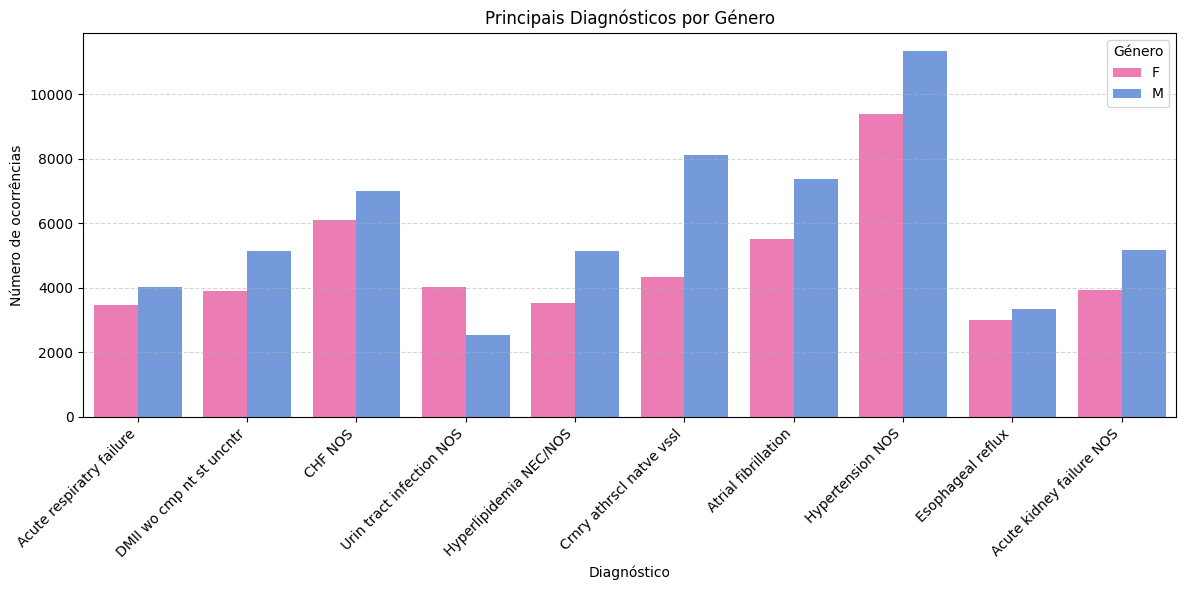

In [54]:
# query="""
# SELECT
#   p.GENDER,
#   dd.SHORT_TITLE AS diagnostico,
#   COUNT(*) AS num_ocorrencias
# FROM
#   `ml-pipeline-459822.data.diagnoses_icd` AS d
# JOIN
#   `ml-pipeline-459822.data.d_icd_diagnoses` AS dd
# ON
#   d.ICD9_CODE = dd.ICD9_CODE
# JOIN
#   `ml-pipeline-459822.data.patients` AS p
# ON
#   d.SUBJECT_ID = p.SUBJECT_ID
# WHERE
#   p.GENDER IN ('M', 'F')
# GROUP BY
#   p.GENDER, dd.SHORT_TITLE
# ORDER BY
#   num_ocorrencias DESC
# LIMIT 1000
# """

# # Lê os dados da query
# df = bpd.read_gbq(query).to_pandas()

# Filtra os 10 diagnósticos mais comuns por género
top_diagnosticos = (
    df.groupby('diagnostico')['num_ocorrencias'].sum()
    .nlargest(10)
    .index.tolist()
)

df_top = df[df['diagnostico'].isin(top_diagnosticos)]

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='diagnostico', y='num_ocorrencias', hue='GENDER', palette=['#FF69B4', '#6495ED'])

plt.title("Principais Diagnósticos por Género")
plt.ylabel("Número de ocorrências")
plt.xlabel("Diagnóstico")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Género')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Top 10 of the most etnicities appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/259934976.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ethnicity_df, x='ETHNICITY', y='num_patients', palette='viridis')


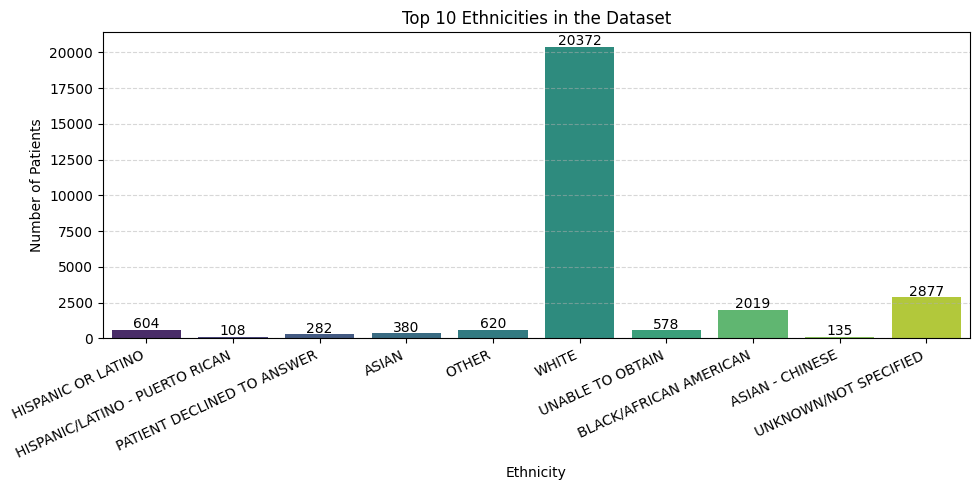

In [ ]:
# # Query para obter o top 10 de etnias com mais pacientes
# query_ethnicity = """
# SELECT
#   ETHNICITY,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ETHNICITY IS NOT NULL
# GROUP BY
#   ETHNICITY
# ORDER BY
#   num_patients DESC
# LIMIT 10
# """

# # Lê os dados da query
# ethnicity_df = bpd.read_gbq(query_ethnicity).to_pandas()

# Plot das etnias mais frequentes
plt.figure(figsize=(10, 5))
sns.barplot(data=ethnicity_df, x='ETHNICITY', y='num_patients', palette='viridis')

# Adicionar valores acima das barras
for index, row in ethnicity_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Top 10 Ethnicities in the Dataset")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Top 10 of the most marital statuses appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1013712401.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=marital_df, x='MARITAL_STATUS', y='num_patients', palette='coolwarm')


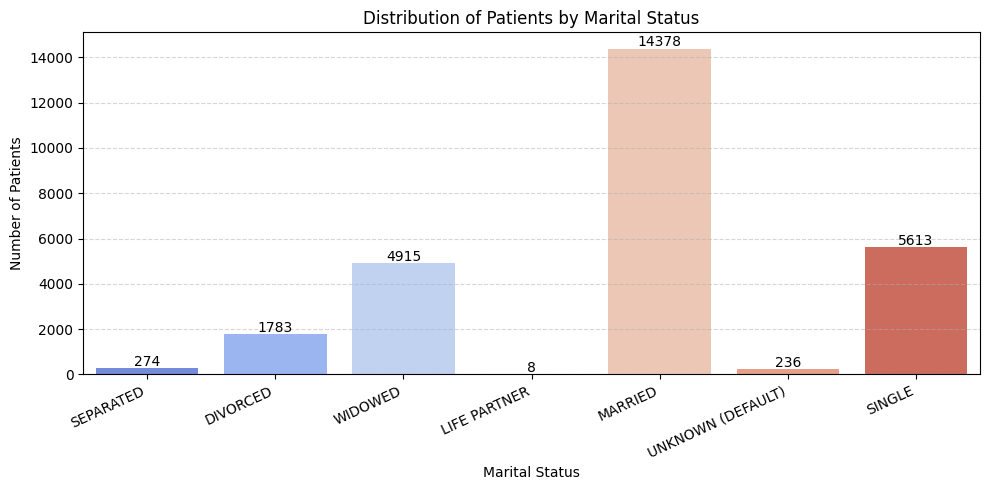

In [56]:
# # Query para obter o número de pacientes por estado civil
# query_marital = """
# SELECT
#   MARITAL_STATUS,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   MARITAL_STATUS IS NOT NULL
# GROUP BY
#   MARITAL_STATUS
# ORDER BY
#   num_patients DESC
# """

# # Lê os dados da query
# marital_df = bpd.read_gbq(query_marital).to_pandas()

# Plot do estado civil dos pacientes
plt.figure(figsize=(10, 5))
sns.barplot(data=marital_df, x='MARITAL_STATUS', y='num_patients', palette='coolwarm')

# Adicionar valores acima das barras
for index, row in marital_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Most frequent insurance types appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/2522397343.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_df, x='INSURANCE', y='num_patients', palette='Set2')


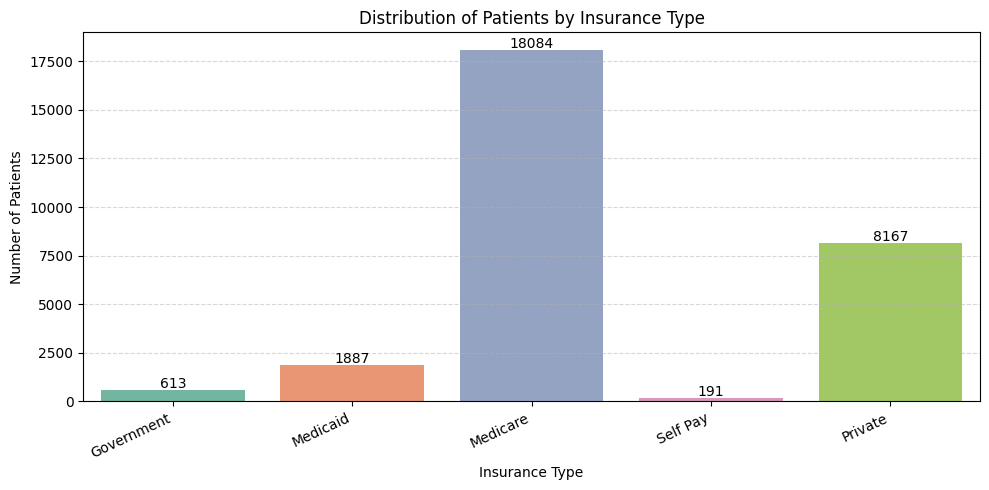

In [ ]:
# # Query to get number of patients per insurance type
# query_insurance = """
# SELECT
#   INSURANCE,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   INSURANCE IS NOT NULL
# GROUP BY
#   INSURANCE
# ORDER BY
#   num_patients DESC
# """

# # Load the data into a DataFrame
# insurance_df = bpd.read_gbq(query_insurance).to_pandas()

# Plotting the distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=insurance_df, x='INSURANCE', y='num_patients', palette='Set2')

# Add count labels above bars
for index, row in insurance_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Insurance Type")
plt.xlabel("Insurance Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of Patients by Age

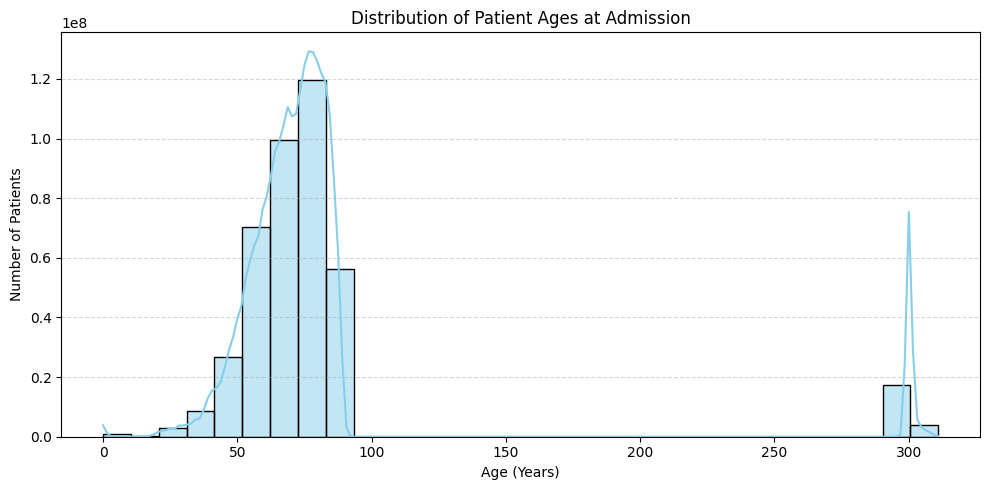

In [ ]:
# # Calculate patient age at the time of admission
# query_age = """
# SELECT
#   SUBJECT_ID,
#   DATE_DIFF(DATE(ADMITTIME), DATE(DOB), YEAR) AS AGE
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   DOB IS NOT NULL AND ADMITTIME IS NOT NULL
# """

# # Load data into a DataFrame
# age_df = bpd.read_gbq(query_age).to_pandas()

# Plotting age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=age_df, x='AGE', bins=30, kde=True, color='darkblue')

plt.title("Distribution of Patient Ages at Admission")
plt.xlabel("Age (Years)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Some age values appear around 300 years, which is not realistic. This probably happens because, in the MIMIC-III dataset, the date of birth is artificially shifted for patients over 89 years old to protect their privacy. As a result, their age is calculated as very high (often around 300). These entries should considered as outliers and therefore excluded or grouped as “90+”.


### Average Length of Stay by Age

Pearson correlation between Age and ICU Length of Stay: -0.0937


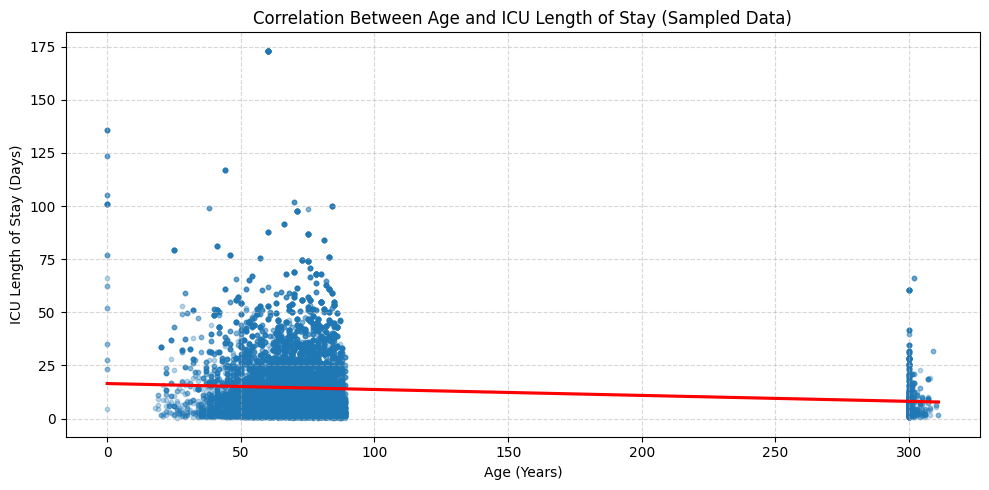

In [ ]:
# # Query to retrieve age and LOS
# query_correlation = """
# SELECT
#   SUBJECT_ID,
#   DATE_DIFF(DATE(ADMITTIME), DATE(DOB), YEAR) AS AGE,
#   LOS
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   DOB IS NOT NULL AND ADMITTIME IS NOT NULL AND LOS IS NOT NULL
# """

# # Load data
# correlation_df = bpd.read_gbq(query_correlation).to_pandas()

# Drop any rows with missing values just in case
correlation_df = correlation_df.dropna(subset=['AGE', 'LOS'])


# Usar só 20 mil linhas aleatórias para o plot
sample_df = correlation_df.sample(n=100000, random_state=42)

# Calculate Pearson correlation coefficient
correlation = sample_df['AGE'].corr(sample_df['LOS'])

# Display the correlation value
print(f"Pearson correlation between Age and ICU Length of Stay: {correlation:.4f}")


plt.figure(figsize=(10, 5))
sns.regplot(data=sample_df, x='AGE', y='LOS', scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.title("Correlation Between Age and ICU Length of Stay (Sampled Data)")
plt.xlabel("Age (Years)")
plt.ylabel("ICU Length of Stay (Days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Hospital Admissions Analysis**

### Number of Hospital Admissions in the Dataset with the 5 most common diseases

In [16]:
raw_features['HADM_ID'].nunique()

np.int64(35918)

### Number of Patients by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18416/1921620465.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pacientes_por_admissao_df, x='ADMISSION_TYPE', y='num_pacientes', palette='Blues_d')


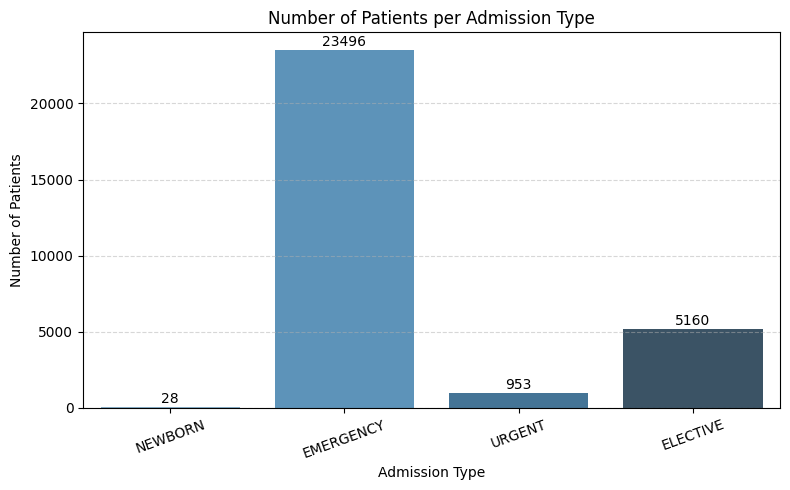

In [ ]:
# # Query para contar o número de pacientes distintos por tipo de admissão
# query_pacientes_por_admissao = """
# SELECT
#   ADMISSION_TYPE,
#   COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   num_pacientes DESC
# """

# # Lê os dados da query
# pacientes_por_admissao_df = bpd.read_gbq(query_pacientes_por_admissao).to_pandas()

# Plot do número de pacientes por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=pacientes_por_admissao_df, x='ADMISSION_TYPE', y='num_pacientes', palette='Blues_d')

# Adicionar contagens
for index, row in pacientes_por_admissao_df.iterrows():
    plt.text(index, row['num_pacientes'] + 100, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Number of Patients per Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18904/2189661857.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_admission_df, x='ADMISSION_TYPE', y='avg_los', palette='Blues_d')


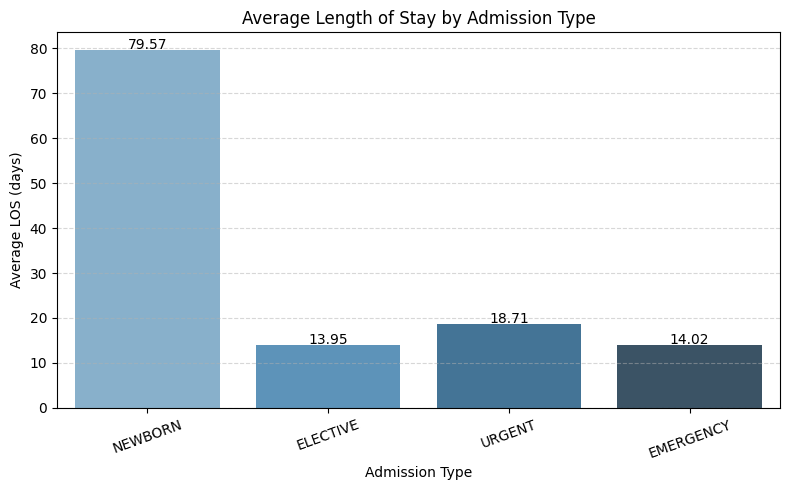

In [ ]:
# # Query para calcular o LOS médio por tipo de admissão
# query_los_admission = """
# SELECT
#   ADMISSION_TYPE,
#   AVG(LOS) AS avg_los
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL AND LOS IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   avg_los DESC
# """

# # Lê os dados da query
# los_admission_df = bpd.read_gbq(query_los_admission).to_pandas()

# Plot do LOS médio por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=los_admission_df, x='ADMISSION_TYPE', y='avg_los', palette='Blues_d')

# Adicionar valores acima das barras
for index, row in los_admission_df.iterrows():
    plt.text(index, row['avg_los'] + 0.2, round(row['avg_los'], 2), ha='center')

plt.title("Average Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average LOS (days)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Hospital Admissions over time distribution

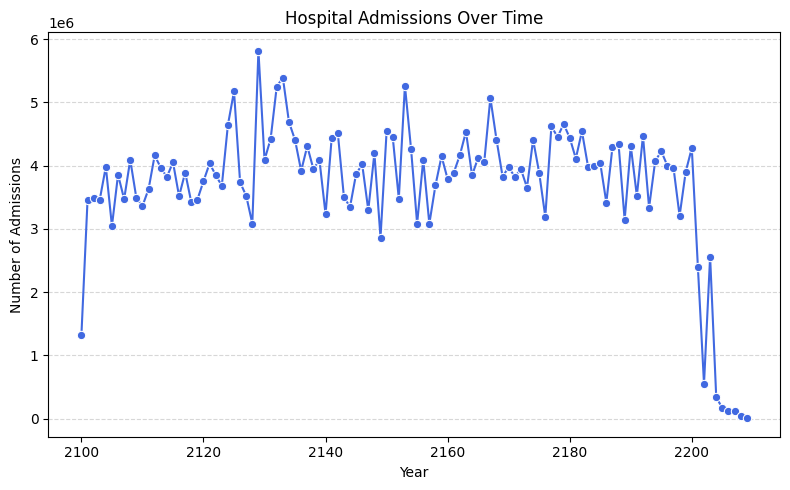

In [ ]:
# query = """
# SELECT
#   EXTRACT(YEAR FROM ADMITTIME) AS year,
#   COUNT(*) AS admissions
# FROM
#   `ml-pipeline-459822.data.raw_features`
# GROUP BY
#   year
# ORDER BY
#   year
# """

# admissions_over_time = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(8, 5))
sns.lineplot(data=admissions_over_time, x='year', y='admissions', marker='o', color='royalblue')
plt.title("Hospital Admissions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Hospital Mortality Rate by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18416/1963936492.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mortalidade_adm_df, x='ADMISSION_TYPE', y='taxa_mortalidade', palette='Reds')


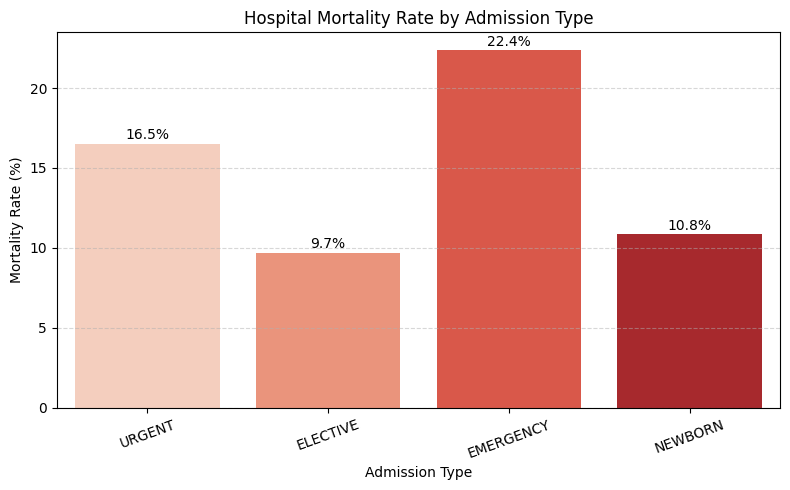

In [20]:
# # Query para calcular a taxa de mortalidade por tipo de admissão
# query_mortalidade_admissao = """
# SELECT
#   ADMISSION_TYPE,
#   COUNT(*) AS total_admissoes,
#   SUM(HOSPITAL_EXPIRE_FLAG) AS total_obitos,
#   SAFE_DIVIDE(SUM(HOSPITAL_EXPIRE_FLAG), COUNT(*)) * 100 AS taxa_mortalidade
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   taxa_mortalidade DESC
# """

# # Lê os dados da query
# mortalidade_adm_df = bpd.read_gbq(query_mortalidade_admissao).to_pandas()

# Plot da taxa de mortalidade por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=mortalidade_adm_df, x='ADMISSION_TYPE', y='taxa_mortalidade', palette='Reds')

# Adicionar valores
for index, row in mortalidade_adm_df.iterrows():
    plt.text(index, row['taxa_mortalidade'] + 0.1, f"{row['taxa_mortalidade']:.1f}%", ha='center', va='bottom')

plt.title("Hospital Mortality Rate by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Mortality Rate (%)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Survival and Mortality Rate 

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18904/668614132.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=surv_death_df, x='Status', y='count', palette=["Red", "Blue"])


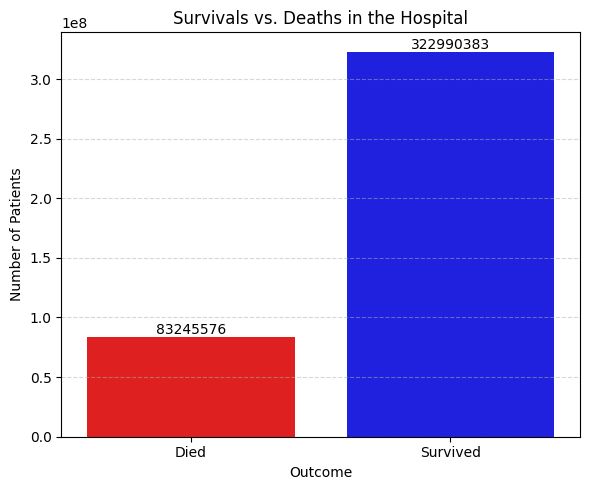

In [ ]:
# # Query para contar sobreviventes e óbitos
# query_surv_death = """
# SELECT
#   HOSPITAL_EXPIRE_FLAG,
#   COUNT(*) AS count
# FROM
#   `ml-pipeline-459822.data.raw_features`
# GROUP BY
#   HOSPITAL_EXPIRE_FLAG
# """

# # Lê os dados da query
# surv_death_df = bpd.read_gbq(query_surv_death).to_pandas()

# Traduz os valores 0 e 1
surv_death_df['Status'] = surv_death_df['HOSPITAL_EXPIRE_FLAG'].map({0: 'Survived', 1: 'Died'})

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(data=surv_death_df, x='Status', y='count', palette=["Red", "Blue"])

# Adicionar valores
for index, row in surv_death_df.iterrows():
    plt.text(index, row['count'] + 500, int(row['count']), ha='center', va='bottom')

plt.title("Survivals vs. Deaths in the Hospital")
plt.xlabel("Outcome")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
---
# ** START FROM HERE **
---
---

# Preprocessing and Feature Engineering

[[ go back to the top ]](#Table-of-contents)

INTRO EXPLAINING THE PREPROCESSING AND FEATURE ENGINEERING STEPS
ONE PREPROCESSING USING BIGFRAMES.PANDAS WITH BIGQUERY AND ONE USING DASK 

## Preprocessing with bigframes.pandas (BigQuery)

In [8]:
# Timing BigQuery preprocessing
start_time_bq = time.time()

In [9]:
df_prep = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

In [10]:
load_time_bq = time.time() - start_time_bq
print(f"Time taken to load data into Pandas: {load_time_bq:.2f} seconds")

Time taken to load data into Pandas: 3.08 seconds


In [11]:
df_prep.shape

(406235959, 28)

In [12]:
df_prep.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 406235959 entries, 0 to 406235958
Data columns (total 28 columns):
  #  Column                Dtype
---  --------------------  ------------------------------
  0  SUBJECT_ID            Int64
  1  HADM_ID               Int64
  2  ICUSTAY_ID            Int64
  3  CHARTTIME             timestamp[us][pyarrow]
  4  VALUEUOM              string
  5  DOB                   timestamp[us, tz=UTC][pyarrow]
  6  ADMITTIME             timestamp[us, tz=UTC][pyarrow]
  7  DISCHTIME             timestamp[us, tz=UTC][pyarrow]
  8  DEATHTIME             timestamp[us, tz=UTC][pyarrow]
  9  HOSPITAL_EXPIRE_FLAG  Int64
 10  ADMISSION_TYPE        string
 11  GENDER                string
 12  ETHNICITY             string
 13  RELIGION              string
 14  LANGUAGE              string
 15  MARITAL_STATUS        string
 16  INSURANCE             string
 17  ITEMID                Int64
 18  LABEL                 string
 19  CATEGORY              string
 20  VAL

In [13]:
df_prep.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,...,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
0,22076,154613,205674,2160-11-22 01:00:00,%,2079-11-28 00:00:00+00:00,2160-11-15 16:25:00+00:00,2160-11-28 16:15:00+00:00,<NA>,0,...,SpO2 Alarm [High],<NA>,100,100.0,<NA>,<NA>,2160-11-21 11:05:48+00:00,2.3177,4019,10
1,11765,196798,244301,2167-05-15 03:00:00,<NA>,2114-01-22 00:00:00+00:00,2167-04-28 22:55:00+00:00,2167-07-02 11:45:00+00:00,<NA>,0,...,Ectopy Type,<NA>,None,<NA>,<NA>,<NA>,2167-04-28 22:56:33+00:00,24.7562,41401,14
2,46156,127108,258962,2134-08-31 21:16:00,insp/min,2053-06-04 00:00:00+00:00,2134-08-16 16:37:00+00:00,2134-09-07 16:47:00+00:00,<NA>,0,...,Respiratory Rate (spontaneous),Respiratory,0,0.0,0,0,2134-08-16 16:38:08+00:00,19.0972,4280,18
3,80454,147903,247883,2175-06-07 12:00:00,<NA>,2105-06-04 00:00:00+00:00,2175-06-06 11:30:00+00:00,2175-06-16 14:00:00+00:00,<NA>,0,...,Dorsal PedPulse L,Cardiovascular (Pulses),Easily Palpable,<NA>,0,0,2175-06-06 10:04:35+00:00,1.2221,4019,8
4,6024,104644,254201,2125-01-02 12:00:00,kg,2057-07-06 00:00:00+00:00,2124-12-31 20:35:00+00:00,2125-01-03 16:30:00+00:00,<NA>,0,...,Previous WeightF,<NA>,66.199996948242188,66.199997,<NA>,<NA>,2124-12-31 20:36:08+00:00,1.7858,4019,1


### Number of unique patients

In [14]:
df_prep['SUBJECT_ID'].nunique()

np.int64(28472)

### Number of missing values 

In [15]:
missing_values = df_prep.isnull().sum()


missing_percentage = (missing_values / len(df_prep)) * 100

missing_data = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percentage,
    'Tipo de Dado': df_prep.dtypes
})


missing_data = missing_data[missing_data['Valores Nulos'] > 0]
print(missing_data.sort_values(by='Porcentagem (%)', ascending=False))

                Valores Nulos  Porcentagem (%)                    Tipo de Dado
DEATHTIME           322990383        79.508073  timestamp[us, tz=UTC][pyarrow]
VALUEUOM            263805454        64.938972                 string[pyarrow]
WARNING             244699816        60.235883                           Int64
ERROR               244699816        60.235883                           Int64
CATEGORY            231786777        57.057179                 string[pyarrow]
VALUENUM            223935703        55.124540                         Float64
LANGUAGE            147914602        36.411007                 string[pyarrow]
MARITAL_STATUS       18661087         4.593657                 string[pyarrow]
RELIGION              2693777         0.663106                 string[pyarrow]
VALUE                 2526502         0.621930                 string[pyarrow]
ICUSTAY_ID             261508         0.064373                           Int64
INTIME                 261508         0.064373  time

Here is an approximate estimate of the percentage of missing values for some columns: 

DEATHTIME: ~80%

WARNING: 60%

ERROR: 60%

LANGUAGE: ~36%


### Remove columns with a high percentage of missing values: 

In [16]:
df_prep = df_prep.drop(columns=['DEATHTIME', 'WARNING', 'ERROR', 'LANGUAGE'])

### Distribution of Patients by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/3558139090.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])


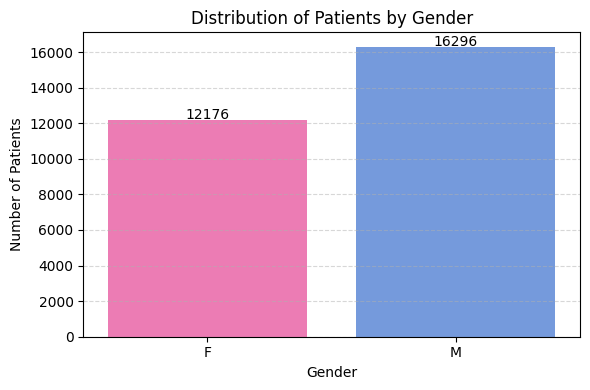

In [17]:
# Load from BigQuery
query = """
SELECT
  GENDER,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  GENDER IS NOT NULL
GROUP BY
  GENDER
ORDER BY
  GENDER
"""
gender_df = bpd.read_gbq(query).to_pandas()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])

# Add counts above bars
for index, row in gender_df.iterrows():
    plt.text(index, row['num_patients'] + 50, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/2756970533.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_by_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])


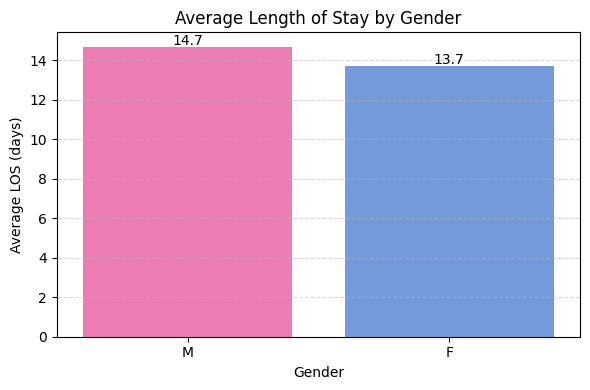

In [18]:
# Load from BigQuery
query = """
SELECT
  GENDER,
  AVG(LOS) AS avg_los
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  GENDER IS NOT NULL AND LOS IS NOT NULL
GROUP BY
  GENDER
ORDER BY
  GENDER
"""
los_by_gender_df = bpd.read_gbq(query).to_pandas()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(data=los_by_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])

# Add average LOS labels above bars
for index, row in los_by_gender_df.iterrows():
    plt.text(index, row['avg_los'] + 0.1, round(row['avg_los'], 1), ha='center')

plt.title("Average Length of Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Patient Age Distribution

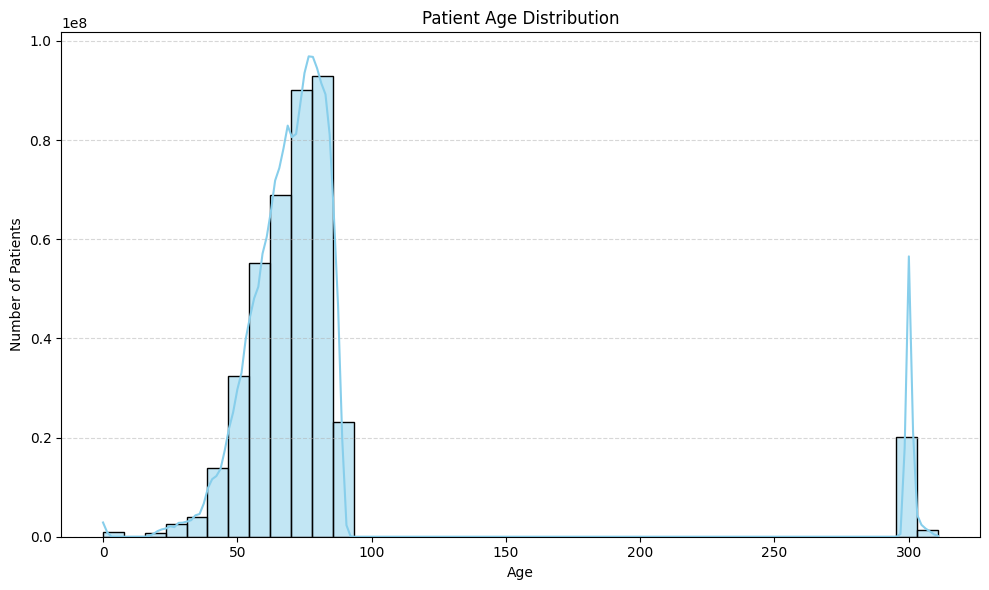

In [19]:
# Load data from BigQuery
query = """
SELECT
  EXTRACT(YEAR FROM ADMITTIME) - EXTRACT(YEAR FROM DOB) AS AGE
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMITTIME IS NOT NULL AND DOB IS NOT NULL
"""
age_df = bpd.read_gbq(query).to_pandas()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(age_df["AGE"], bins=40, kde=True, color='skyblue')

plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Age

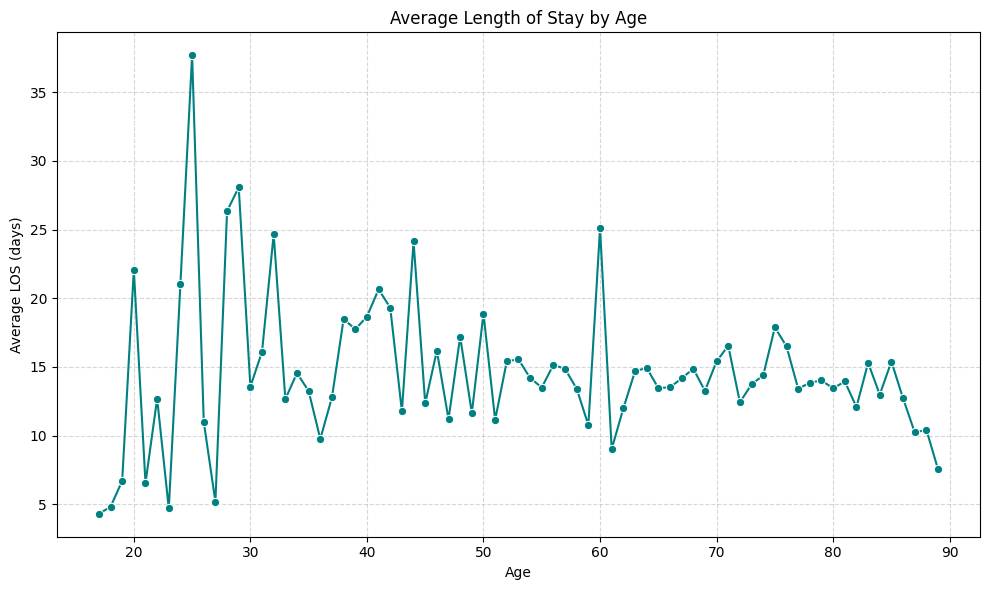

In [20]:
query = """
WITH AgeLosData AS (
  SELECT
    EXTRACT(YEAR FROM ADMITTIME) - EXTRACT(YEAR FROM DOB) AS AGE,
    LOS
  FROM
    `ml-pipeline-459822.data.raw_features`
  WHERE
    ADMITTIME IS NOT NULL
    AND DOB IS NOT NULL
    AND LOS > 0
)

SELECT
  AGE,
  AVG(LOS) AS avg_los
FROM
  AgeLosData
WHERE
  AGE > 0 AND AGE < 120
GROUP BY
  AGE
ORDER BY
  AGE
"""

age_los_df = bpd.read_gbq(query).to_pandas()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.lineplot(data=age_los_df, x="AGE", y="avg_los", marker='o', color="teal")

plt.title("Average Length of Stay by Age")
plt.xlabel("Age")
plt.ylabel("Average LOS (days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Number of Patients by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/4096378576.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=patients_count, x="ADMISSION_TYPE", y="num_patients", palette="coolwarm")


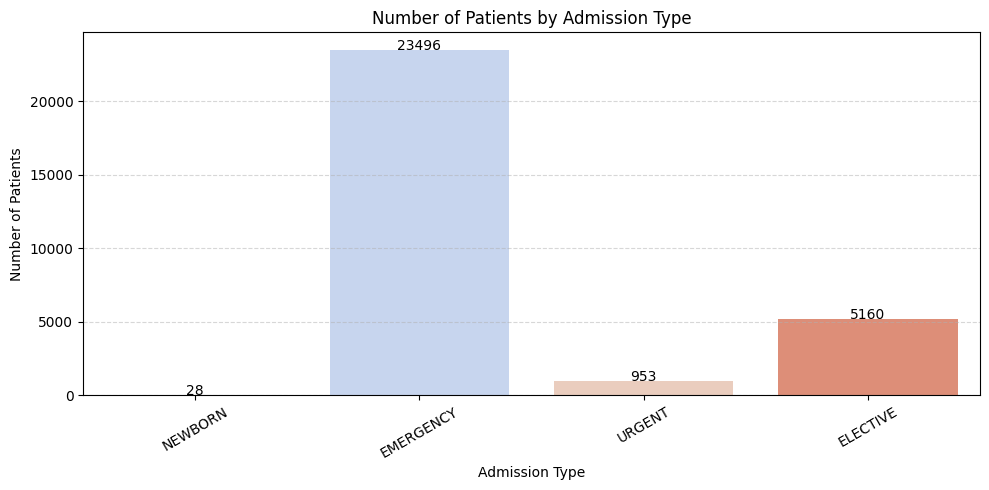

In [21]:
# Run the SQL query and load results into a pandas DataFrame (replace bpd.read_gbq with your preferred method)
query = """
SELECT
  ADMISSION_TYPE,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_patients DESC
"""
patients_count = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=patients_count, x="ADMISSION_TYPE", y="num_patients", palette="coolwarm")

for index, row in patients_count.iterrows():
    plt.text(index, row['num_patients'] + 5, int(row['num_patients']), ha='center')

plt.title("Number of Patients by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Length of Stay by Admission Type

""" The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click here for more info. 
View Jupyter log for further details. """

It took 30 minutes to run the code bellow just to get this error message. 

In [22]:
# query = """
# SELECT
#   ADMISSION_TYPE,
#   LOS
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL
#   AND LOS IS NOT NULL
#   AND LOS > 0
# """
# admission_los_df = bpd.read_gbq(query).to_pandas()

# plt.figure(figsize=(12, 6))
# sns.boxplot(data=admission_los_df, x="ADMISSION_TYPE", y="LOS", palette="Set2")

# plt.title("Length of Stay by Admission Type")
# plt.xlabel("Admission Type")
# plt.ylabel("Length of Stay (days)")
# plt.xticks(rotation=30)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

### Distribution of Hospital Length of Stay (LOS)

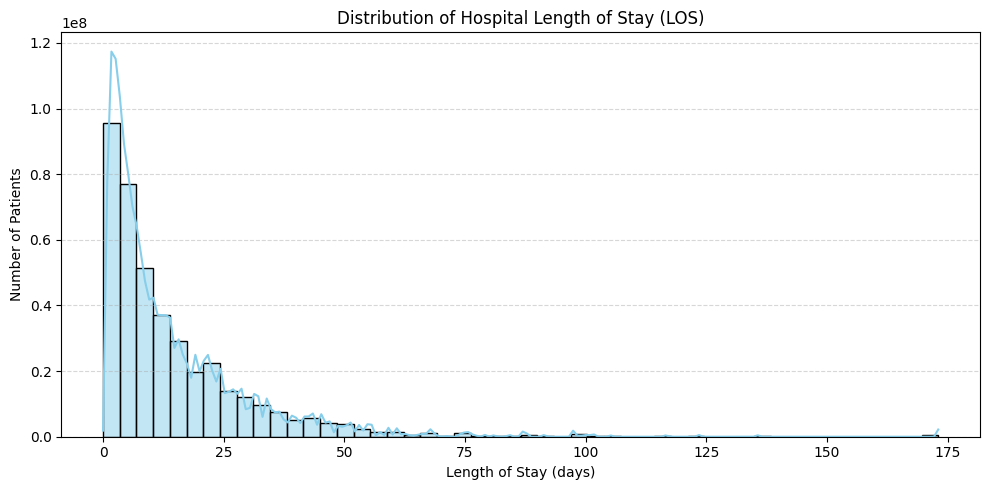

In [23]:
query = """
SELECT LOS
FROM `ml-pipeline-459822.data.raw_features`
WHERE LOS IS NOT NULL
"""

los_data = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 5))
sns.histplot(los_data["LOS"], bins=50, kde=True, color='skyblue')

plt.title("Distribution of Hospital Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**AGE**

Age is one of the variables we consider important when predicting the length of stay of a patient in the Intensive Care Unit. 
However, according to the documentation, there are age values above 300, which need to be filtered out

300 = 90

301 = 91

(...)

In [24]:
df_prep['AGE'] = df_prep['ADMITTIME'].dt.year - df_prep['DOB'].dt.year
df_prep = df_prep.assign(
    AGE = df_prep['AGE'].where(df_prep['AGE'] < 300, df_prep['AGE'] - 300 + 90)
)
df_prep = df_prep.drop(columns=['ADMITTIME', 'DOB'])


**Repeated Valuess**:

In [25]:
duplicados = df_prep[df_prep.duplicated()]
print(f"Número de linhas duplicadas: {len(duplicados)}")

Número de linhas duplicadas: 0


**Checking categorial columns**

In [26]:

string_cols = [col for col, dtype in zip(df_prep.columns, df_prep.dtypes) if dtype == "string"]

for col in string_cols:
    count = df_prep[col].nunique()
    print(f"{col}: {count} distinct values")

VALUEUOM: 104 distinct values
ADMISSION_TYPE: 4 distinct values
GENDER: 2 distinct values
ETHNICITY: 41 distinct values
RELIGION: 20 distinct values
MARITAL_STATUS: 7 distinct values
INSURANCE: 5 distinct values
LABEL: 4559 distinct values
CATEGORY: 56 distinct values
VALUE: 268260 distinct values
ICD9_CODE: 5 distinct values


We will now remove the columns containing strings, as they are unlikely to be relevant for the current classification task.

In [27]:
# 2. Remover colunas indesejadas
colunas_a_remover = ['RELIGION', 'ETHNICITY', 'MARITAL_STATUS', 'INSURANCE']
df_prep = df_prep.drop(columns=colunas_a_remover)


**Gender**

Convert the gender columns to:  
    
M -> 1

F -> 0

In [28]:

df_prep["GENDER"] = df_prep["GENDER"].map({"F": 0, "M": 1})


Since the 'LABEL' table contains many distinct values, they are grouped into categories in the 'CATEGORY' columns, so we only need to keep this columns as relevant 

In [29]:
df_prep["CATEGORY"].head(10)

0                       <NA>
1                       <NA>
2                Respiratory
3    Cardiovascular (Pulses)
4                       <NA>
5          Skin - Impairment
6               Hemodynamics
7               Neurological
8                       <NA>
9                 Treatments
Name: CATEGORY, dtype: string

**Admission Type**

In [30]:
df_prep["ADMISSION_TYPE"] = df_prep["ADMISSION_TYPE"].map({"EMERGENCY": 0, "ELECTIVE": 1, "URGENT": 2, "NEWBORN": 3})

In [31]:
end_time_bq = time.time()
bq_duration = end_time_bq - start_time_bq
print(f"BigQuery preprocessing time: {bq_duration:.2f} seconds")

BigQuery preprocessing time: 1073.60 seconds


## Preprocessing with Dask

In [32]:
# Timing Dask preprocessing
start_time_dask = time.time()

### Initially, we tried to load the entire raw_features table directly into memory using bpd.read_gbq(), but the query failed because the response size exceeded BigQuery’s limit for interactive queries (GenericGBQException: Reason: 403 GET ... Response too large to return. Consider specifying a destination table in your job configuration. For more details, see ...). To solve this, we limit the data to 100,000 rows using the LIMIT clause in our SQL query. This allowed us to work with a manageable subset of the data while still being able to perform our analysis and preprocessing steps.

Unrunable code bellow to see the error message.

In [33]:
# df_pandas = pandas_gbq.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features`")

In [34]:
# Read from BigQuery into Pandas first
df_pandas = pandas_gbq.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features` LIMIT 100000")

Downloading: 100%|██████████|


In [35]:
load_time_dask = time.time() - start_time_dask
print(f"Time taken to load data into Pandas: {load_time_dask:.2f} seconds")

Time taken to load data into Pandas: 16.45 seconds


### Why pandas_gbq and not bpd?? - using bpd.read_gbq() to load data from BigQuery, returns a BigFrames DataFrame, which is not directly compatible with libraries like Dask or PySpark. Since dd.from_pandas() specifically expects a standard pandas DataFrame, we switched to pandas_gbq to load the data as a native pandas DataFrame, making it easier to integrate with other Python data processing tools. (TypeError: Input must be a pandas DataFrame or Series.)

Unrunable code bellow to see the error message.

In [36]:
# Convert to Dask
df_dask = dd.from_pandas(df_pandas, npartitions=4)

In [37]:
# df = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features` LIMIT 100000")
# df_dask = dd.from_pandas(df_pandas2, npartitions=4)


In [38]:
# Get shape
n_rows = df_dask.shape[0].compute()
n_cols = len(df_dask.columns)

print(f"Dask DataFrame shape: ({n_rows}, {n_cols})")

Dask DataFrame shape: (100000, 28)


In [39]:
# Now use Dask for parallel computation
df_dask.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 28 entries, SUBJECT_ID to SEQ_NUM
dtypes: Int64(8), datetime64[us, UTC](5), datetime64[us](1), float64(2), string(12)

In [40]:
df_dask

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,ETHNICITY,RELIGION,LANGUAGE,MARITAL_STATUS,INSURANCE,ITEMID,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Int64,Int64,Int64,datetime64[us],string,"datetime64[us, UTC]","datetime64[us, UTC]","datetime64[us, UTC]","datetime64[us, UTC]",Int64,string,string,string,string,string,string,string,Int64,string,string,string,float64,Int64,Int64,"datetime64[us, UTC]",float64,string,Int64
25000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99999,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Number of unique patients

In [41]:
df_dask['SUBJECT_ID'].nunique().compute()

np.int64(8424)

### Number of missing values

In [42]:
missing_values = df_dask.isnull().sum().compute()
total_rows = df_dask.shape[0].compute()
missing_percentage = (missing_values / total_rows) * 100

missing_data = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percentage,
    'Tipo de Dado': df_dask.dtypes
})

missing_data = missing_data[missing_data['Valores Nulos'] > 0]
print(missing_data.sort_values(by='Porcentagem (%)', ascending=False))

                Valores Nulos  Porcentagem (%)         Tipo de Dado
DEATHTIME               80233           80.233  datetime64[us, UTC]
WARNING                 65757           65.757                Int64
ERROR                   65757           65.757                Int64
VALUEUOM                63558           63.558      string[pyarrow]
CATEGORY                62372           62.372      string[pyarrow]
VALUENUM                54344           54.344              float64
LANGUAGE                40136           40.136      string[pyarrow]
MARITAL_STATUS           2867            2.867      string[pyarrow]
RELIGION                 1761            1.761      string[pyarrow]
VALUE                     704            0.704      string[pyarrow]
ICUSTAY_ID                 61            0.061                Int64
INTIME                     61            0.061  datetime64[us, UTC]
LOS                        61            0.061              float64


In [43]:
df_dask = df_dask.drop(columns=['DEATHTIME', 'WARNING', 'ERROR', 'LANGUAGE'])

### Distribution of Patients by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/1207103026.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])


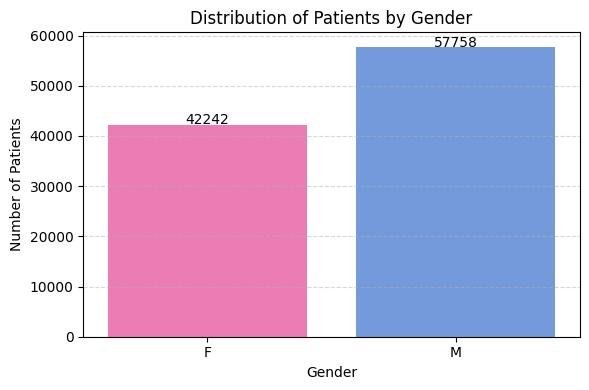

In [44]:
# Group by gender and count
gender_dask = df_dask.groupby("GENDER")["SUBJECT_ID"].count().reset_index()
gender_dask = gender_dask.rename(columns={"SUBJECT_ID": "num_patients"})

# Compute the result (this triggers Dask computation)
gender_df = gender_dask.compute()


plt.figure(figsize=(6, 4))
sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])

# Add counts above bars
for index, row in gender_df.iterrows():
    plt.text(index, row['num_patients'] + 50, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/1655435040.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_by_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])


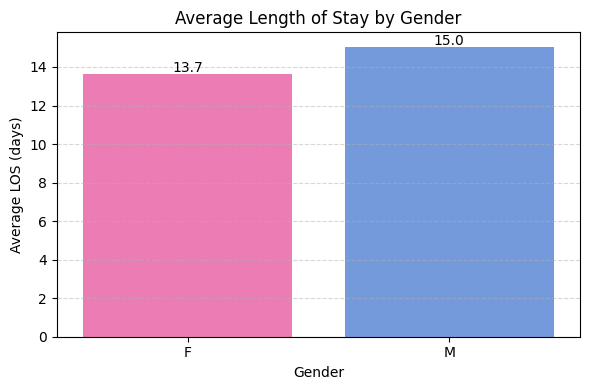

In [45]:
# Group by gender and calculate mean LOS
los_by_gender_dask = df_dask.groupby("GENDER")["LOS"].mean().reset_index()
los_by_gender_dask = los_by_gender_dask.rename(columns={"LOS": "avg_los"})

# Trigger computation
los_by_gender_df = los_by_gender_dask.compute()

plt.figure(figsize=(6, 4))
sns.barplot(data=los_by_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])

# Add values above bars
for index, row in los_by_gender_df.iterrows():
    plt.text(index, row['avg_los'] + 0.1, round(row['avg_los'], 1), ha='center')

plt.title("Average Length of Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Patient Age Distribution

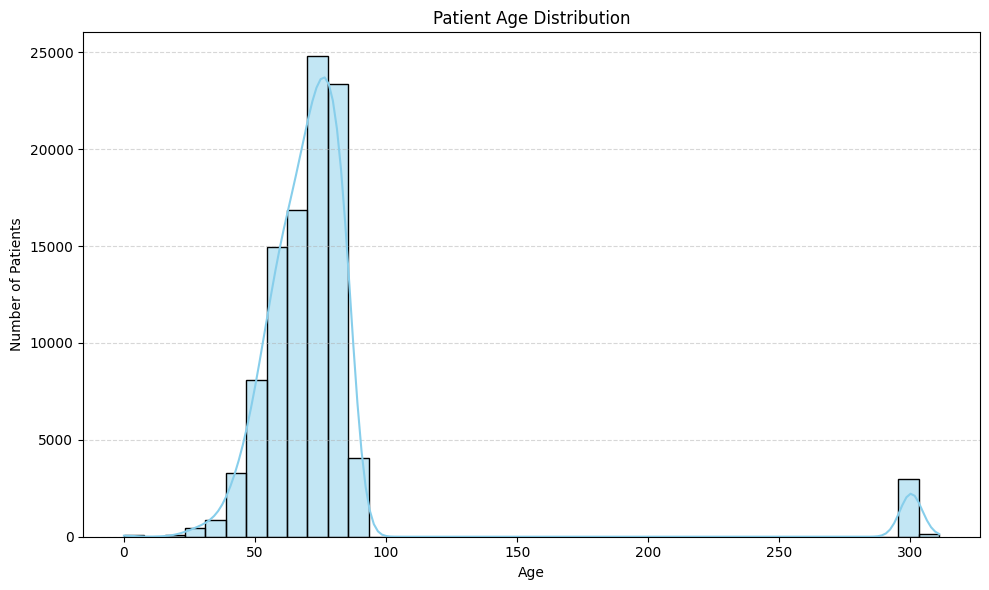

In [46]:
# Make sure columns are datetime
df_dask["ADMITTIME"] = dd.to_datetime(df_dask["ADMITTIME"])
df_dask["DOB"] = dd.to_datetime(df_dask["DOB"])

# Compute age in years (floor division)
df_dask["AGE"] = (df_dask["ADMITTIME"].dt.year - df_dask["DOB"].dt.year)

# Compute histogram data in Pandas
age_df = df_dask[["AGE"]].dropna().compute()

plt.figure(figsize=(10, 6))
sns.histplot(age_df["AGE"], bins=40, kde=True, color='skyblue')

plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Age

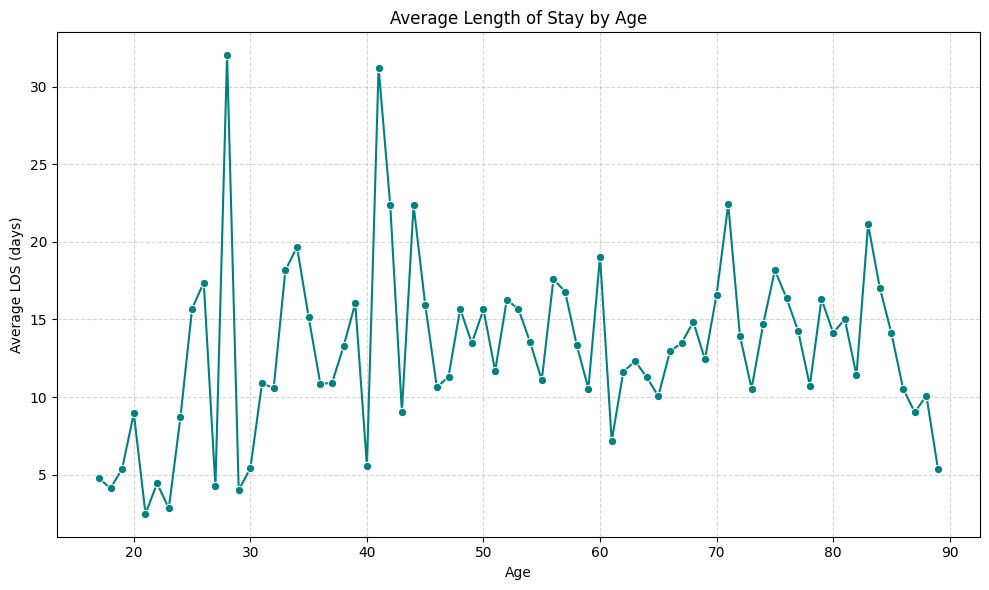

In [47]:
# Group by AGE and calculate average LOS
age_avg_los = df_dask[["AGE", "LOS"]].dropna()
age_avg_los = age_avg_los[(age_avg_los["AGE"] > 0) & (age_avg_los["AGE"] < 120)]
age_avg_los = age_avg_los[age_avg_los["LOS"] > 0]

# Group and compute
avg_los_by_age = age_avg_los.groupby("AGE")["LOS"].mean().compute().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_los_by_age, x="AGE", y="LOS", marker='o', color="teal")

plt.title("Average Length of Stay by Age")
plt.xlabel("Age")
plt.ylabel("Average LOS (days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Number of Patients by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/4001159421.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=patients_count, x="ADMISSION_TYPE", y="num_patients", palette="coolwarm")


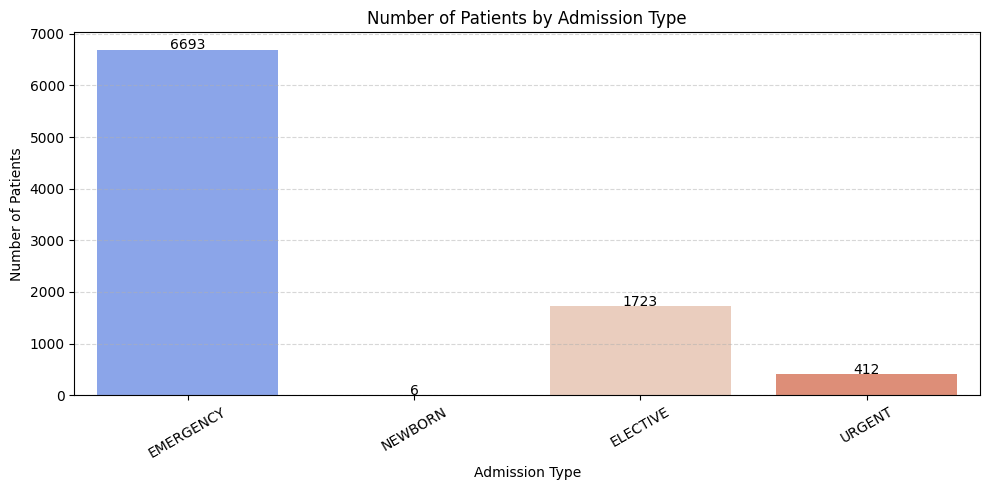

In [48]:
# Select relevant columns and drop nulls
patients_adm_dask = df_dask[["SUBJECT_ID", "ADMISSION_TYPE"]].dropna()

# Count distinct patients per admission type
patients_count = patients_adm_dask.groupby("ADMISSION_TYPE")["SUBJECT_ID"].nunique().compute().reset_index()

# Rename columns for clarity
patients_count.columns = ["ADMISSION_TYPE", "num_patients"]

plt.figure(figsize=(10, 5))
sns.barplot(data=patients_count, x="ADMISSION_TYPE", y="num_patients", palette="coolwarm")

# Add counts above bars
for index, row in patients_count.iterrows():
    plt.text(index, row['num_patients'] + 5, int(row['num_patients']), ha='center')

plt.title("Number of Patients by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Length of Stay by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_37816/3302835705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=admission_los_df, x="ADMISSION_TYPE", y="LOS", palette="Set2")


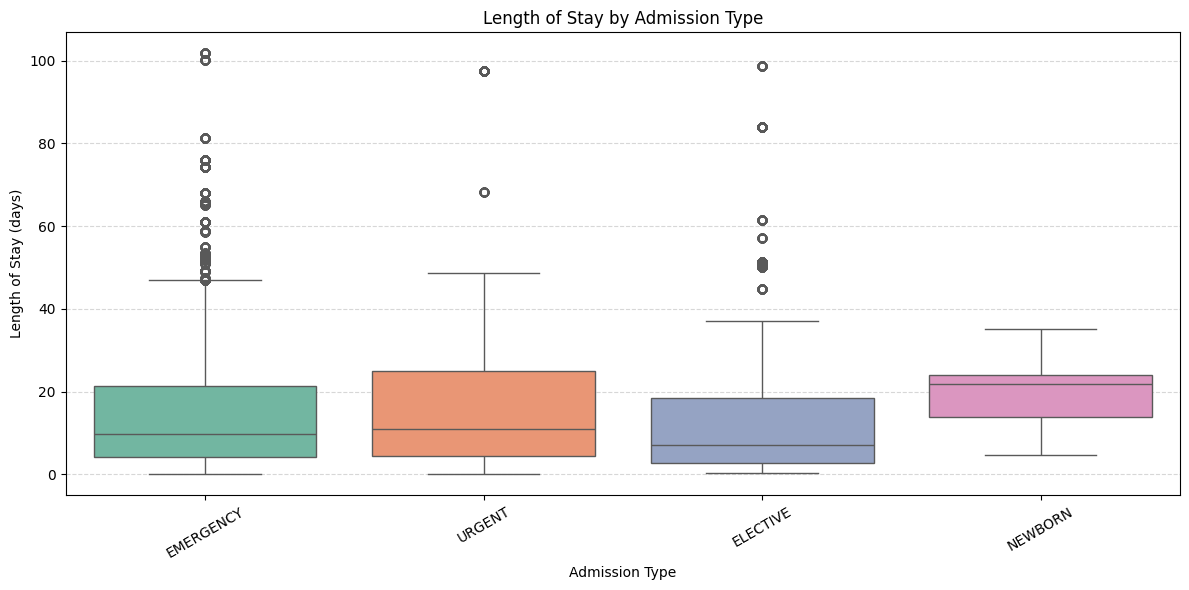

In [49]:
# Filter out nulls in ADMISSION_TYPE and LOS
admission_los_dask = df_dask[["ADMISSION_TYPE", "LOS"]].dropna()

# Optional: Filter out non-positive LOS values
admission_los_dask = admission_los_dask[admission_los_dask["LOS"] > 0]

# Compute into pandas DataFrame for plotting
admission_los_df = admission_los_dask.compute()

plt.figure(figsize=(12, 6))
sns.boxplot(data=admission_los_df, x="ADMISSION_TYPE", y="LOS", palette="Set2")

plt.title("Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Length of Stay (days)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of Hospital Length of Stay (LOS)

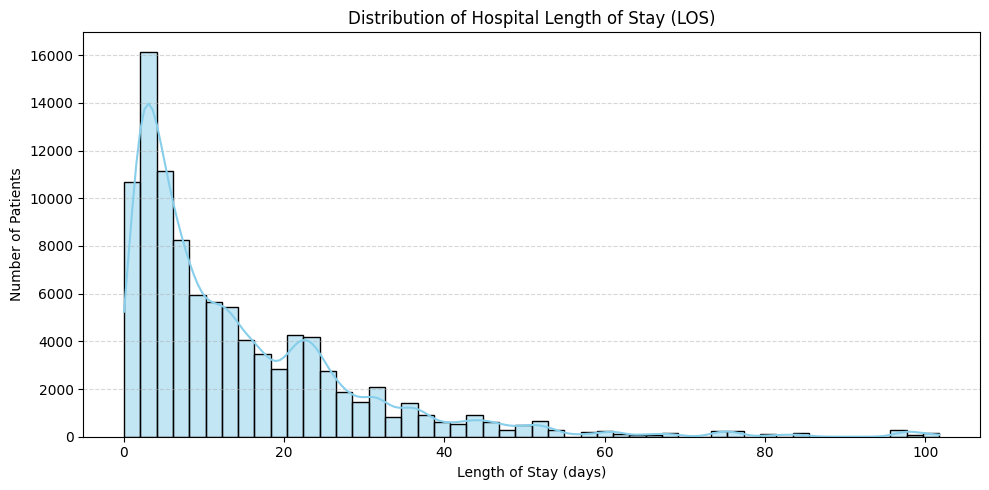

In [50]:
# Select LOS column and drop nulls
los_data = df_dask["LOS"].dropna().compute()

plt.figure(figsize=(10, 5))
sns.histplot(los_data, bins=50, kde=True, color='skyblue')

plt.title("Distribution of Hospital Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [51]:
# Compute AGE
df_dask['AGE'] = df_dask['ADMITTIME'].dt.year - df_dask['DOB'].dt.year

# Adjust AGE if it's over 300 (handling year offset issue)
df_dask['AGE'] = df_dask['AGE'].where(df_dask['AGE'] < 300, df_dask['AGE'] - 300 + 90)

# Drop columns
df_dask = df_dask.drop(columns=['ADMITTIME', 'DOB'])

In [52]:
# Count each row's occurrence
duplicates_count = df_dask.groupby(df_dask.columns.tolist()).size()

# Filter rows that appear more than once
duplicated_rows = duplicates_count[duplicates_count > 1]

# Count number of duplicated rows
num_duplicated_rows = duplicated_rows.count().compute()

print(f"Número de linhas duplicadas: {num_duplicated_rows}")

Número de linhas duplicadas: 0


In [53]:
# Identify string/object columns
string_cols = [col for col, dtype in zip(df_dask.columns, df_dask.dtypes) if dtype == object or "string" in str(dtype)]

# Compute number of distinct values in each string column
for col in string_cols:
    try:
        count = df_dask[col].nunique().compute()
        print(f"{col}: {count} distinct values")
    except Exception as e:
        print(f"Could not compute nunique for column {col}: {e}")

VALUEUOM: 72 distinct values
ADMISSION_TYPE: 4 distinct values
GENDER: 2 distinct values
ETHNICITY: 38 distinct values
RELIGION: 4 distinct values
MARITAL_STATUS: 7 distinct values
INSURANCE: 5 distinct values
LABEL: 1657 distinct values
CATEGORY: 43 distinct values
VALUE: 4740 distinct values
ICD9_CODE: 5 distinct values


In [54]:
# 2. Remove unwanted columns in Dask
colunas_a_remover = ['RELIGION', 'ETHNICITY', 'MARITAL_STATUS', 'INSURANCE']
df_dask = df_dask.drop(columns=colunas_a_remover)

In [55]:
df_dask["GENDER"] = df_dask["GENDER"].map(
    {"F": 0, "M": 1},
    meta=('GENDER', 'int64')
)

In [56]:
df_dask["ADMISSION_TYPE"] = df_dask["ADMISSION_TYPE"].map(
    {
        "EMERGENCY": 0,
        "ELECTIVE": 1,
        "URGENT": 2,
        "NEWBORN": 3
    },
    meta=('ADMISSION_TYPE', 'int64')  # explicitly set output type
)

In [57]:
end_time_dask = time.time()
dask_duration = end_time_dask - start_time_dask
print(f"Dask preprocessing time: {dask_duration:.2f} seconds")

Dask preprocessing time: 19.24 seconds


## Comparing the two approaches by time taken to run the same preprocessing steps

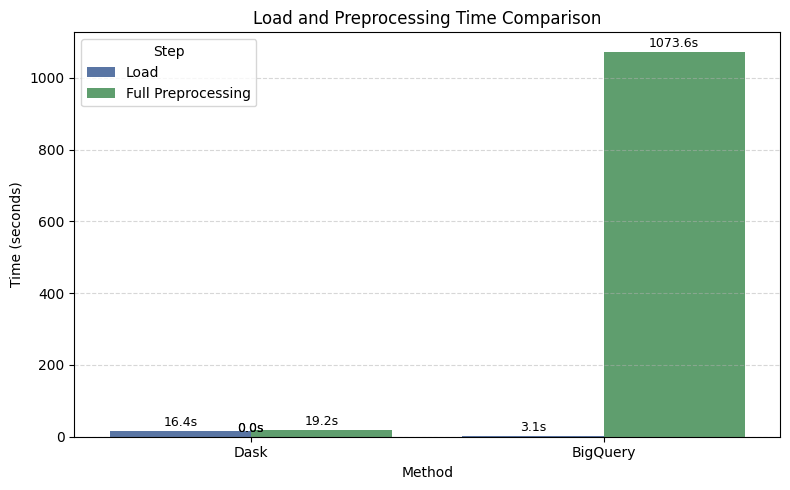

In [58]:
# Create a DataFrame with all timings
times_df = pd.DataFrame({
    'Method': ['Dask', 'Dask', 'BigQuery', 'BigQuery'],
    'Step': ['Load', 'Full Preprocessing', 'Load', 'Full Preprocessing'],
    'Time (seconds)': [load_time_dask, dask_duration, load_time_bq, bq_duration]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=times_df, x='Method', y='Time (seconds)', hue='Step', palette=['#4C72B0', '#55A868'])

# Add text annotations on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}s',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=9, xytext=(0, 1),
                textcoords='offset points',
                color='black')

plt.title("Load and Preprocessing Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Method")
plt.legend(title='Step')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
---
# ** MACHINE LEARNING **
---
---

# Data Preparation
[[ go back to the top ]](#Table-of-contents)

-------

**Big Frames**

## **TRAIN**

**Transforming the DataFrame for Model Training:**

**Fundamental Principles for LOS Prediction:**

**Prediction Point:** You need to decide when the prediction will be made. Typicaly, this occurs right after ICU (or hospital) admission, using only the information available up to that moment. 

**Observation Window:** This is the period after admission from which you will extract features. We will compare and test the result with the first **24 and 48 hours**

-> 24 HOURS

**STEP 1: Define the Time Window (Observation Window and Prediction Point)**

We will define that the prediction will be using data from the first 24 hours of the ICU stay.

Prediction Point: At the moment of ICU admission (INTIME)

Observation Window: From INTIME to INTIME + 24 hours

In [ ]:
observation_window_hours = 24
df_prep['OBSERVATION_WINDOW_END'] = df_prep['INTIME'] + datetime.timedelta(hours=observation_window_hours)

print(df_prep[['ICUSTAY_ID', 'INTIME', 'OBSERVATION_WINDOW_END']].head().to_pandas())

   ICUSTAY_ID                     INTIME     OBSERVATION_WINDOW_END
0      205674  2160-11-21 11:05:48+00:00  2160-11-22 11:05:48+00:00
1      244301  2167-04-28 22:56:33+00:00  2167-04-29 22:56:33+00:00
2      258962  2134-08-16 16:38:08+00:00  2134-08-17 16:38:08+00:00
3      247883  2175-06-06 10:04:35+00:00  2175-06-07 10:04:35+00:00
4      254201  2124-12-31 20:36:08+00:00  2125-01-01 20:36:08+00:00


**STEP 2: FEATURE ENGINEERING**

This is the most critical part. 

We need to create features based only on data available within the OBSERVATION_WINDOW_END

The following code prepares an input dataset for **Machine Learning models**, with granularity at the ICUSTAY_ID level, using time-series data from vital signs or measurements in the CHARTEVENTS; extracted within a 24-hour observation window. 

First, we ensure that the time fields are in the correct format (Datetime), which is essential for properly comparing data and filtering time intervals. This step is important beacause operations like (CHARTIME >= INTIME) only work correctly if both fields are in datetime format. 

In [34]:

for col in ['INTIME', 'CHARTTIME', 'OBSERVATION_WINDOW_END']:
    if col in df_prep.columns:
        df_prep[col] = bpd.to_datetime(df_prep[col])
    else:
        raise ValueError(f"Coluna '{col}' necessária mas não encontrada.")

**Filtering events within the observation window**

Now, we will select only the events (measurements) that occurred between the start of the ICU stay (INTIME) and the end of the observation window. This allows us to build features based on measurements taken at the beginning of the admission, which simulates a realistic prediction scenario.

In [35]:

events_in_window_df = df_prep[
    (df_prep['CHARTTIME'] >= df_prep['INTIME']) &
    (df_prep['CHARTTIME'] <= df_prep['OBSERVATION_WINDOW_END'])
]

**Filter by specific ITEMIDs**

Filter only the events of interest. The list of IDs is quite large, so reducing the data volume is essential, while keeping clinically relevant measurements for the model. This makes aggregation and model training more efficient and interpretable.

In [ ]:
# Supondo que df_prep já está carregado e filtrado pelas 5 doenças mais comuns
# Exemplo de como df_prep poderia parecer (substitua pelos seus dados reais):
# df_prep = pd.DataFrame({
#     'SUBJECT_ID': [1, 1, 2, 2, 3, 3, 1, 2, 3, 1, 2, 3, 4, 4, 4, 5, 5],
#     'HADM_ID': [10, 10, 20, 20, 30, 30, 10, 20, 30, 10, 20, 30, 40, 40, 40, 50, 50],
#     'ITEMID': [220045, 220181, 220045, 225677, 220181, 220045, 220045, 225677, 220181, 226537, 220045, 225677, 220210, 220210, 220045, 220045, 220181],
#     'VALUENUM': [98, 120, 100, 25, 115, 95, 99, 22, 118, 1, 101, 23, 70, 72, 97, 96, 122],
#     # ... outras colunas ...
# })
# print("DataFrame original (exemplo):")
# print(df_prep.head())
# print(f"Número de linhas original: {len(df_prep)}")
# print(f"Número de ITEMIDs únicos original: {df_prep['ITEMID'].nunique()}")

# 1. Encontrar os 10 ITEMIDs mais comuns
# Se a sua coluna de códigos de item tiver um nome diferente, ajuste 'ITEMID' abaixo.
coluna_itemid = 'ITEMID' # Confirme o nome da sua coluna

contagem_itemids = df_prep[coluna_itemid].value_counts()
top_15_itemids = list(contagem_itemids.head(15).index)

print(f"\n The 15th more communs items are: {top_15_itemids}")




 The 15th more communs items are: [211, 742, 646, 618, 212, 161, 128, 550, 1125, 220045, 220210, 220277, 159, 1484, 220048]


(justificar o porque destes id)

In [41]:

selected_itemids_list = [
    211, 742, 646, 618, 212, 161, 128, 550, 1125, 220045, 220210, 220277, 159, 1484, 220048,
] 



final_events_for_agg = events_in_window_df[events_in_window_df['ITEMID'].isin(selected_itemids_list)]

**Feature name cleaning**

Converts the LABEL names (such as “Heart Rate”) into consistent names to be used as column names. This is important as it improves readability and avoids issues with spaces or case sensitivity.

In [42]:


final_events_for_agg['FEATURE_BASE_NAME'] = final_events_for_agg['LABEL'].str.lower().str.replace(" ", "_")

**Aggregation of values**

We now summarize the measurements of each FEATURE_BASE_NAME by ICUSTAY_ID, applying statistics such as mean, standard deviation, maximum, and minimum.

To predict the Length of Stay, it is necessary to transform these time series into fixed features per patient, making them compatible with tabular Machine Learning models.

In [43]:

aggregations_to_perform = ['mean', 'min', 'max', 'std', 'count']
print(f"Agregando VALUENUM por ICUSTAY_ID e FEATURE_BASE_NAME para: {aggregations_to_perform}...")

aggregated_data = final_events_for_agg.groupby(
    ['ICUSTAY_ID', 'FEATURE_BASE_NAME']
)['VALUENUM'].agg(aggregations_to_perform).reset_index()

Agregando VALUENUM por ICUSTAY_ID e FEATURE_BASE_NAME para: ['mean', 'min', 'max', 'std', 'count']...


**Pivot data to columns by feature**

The next step involves formatting the DataFrame into the structure expected by regression models: a fixed-length feature vector per sample.
To achieve this, we transform the aggregated data so that each feature becomes a column with suffixes like _mean, _std, etc.

In [44]:

print("Pivotando dados para criar colunas de features...")
all_pivoted_features_dfs = []

for agg_func in aggregations_to_perform:
    if agg_func not in aggregated_data.columns:
        print(f"Aviso: Agregação '{agg_func}' não encontrada em aggregated_data. Pulando.")
        continue

    pivot_df = aggregated_data.pivot_table(
        index='ICUSTAY_ID',
        columns='FEATURE_BASE_NAME', 
        values=agg_func 
    ).reset_index()
    
    cols_to_rename = {
        col: f"{col}_{agg_func}" 
        for col in pivot_df.columns if col != 'ICUSTAY_ID'
    }
    pivot_df = pivot_df.rename(columns=cols_to_rename)
    all_pivoted_features_dfs.append(pivot_df)

Pivotando dados para criar colunas de features...


**Create the base DataFrame with static data**

In addition to the aggregated temporal features, we now need to decide which static columns to keep that may be important for predicting the length of stay in the Intensive Care Unit.

Therefore, we will create a DataFrame containing demographic or administrative static data (e.g., type of admission) for each patient.

In [45]:

print("Criando DataFrame base por ICUSTAY_ID...")
static_columns_to_keep = [
    'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME','LOS', 
     'GENDER', 'ADMISSION_TYPE', 'CATEGORY', 'AGE'
   
]


actual_static_cols = [col for col in static_columns_to_keep if col in df_prep.columns]
if 'ICUSTAY_ID' not in actual_static_cols:
    raise ValueError("ICUSTAY_ID deve estar em actual_static_cols para criar o df base.")

df_icustay_base = df_prep[actual_static_cols].drop_duplicates(subset=['ICUSTAY_ID']).copy()




if not all_pivoted_features_dfs:
    print("Nenhuma feature pivotada foi gerada. df_icustay_base não será modificado com features de medições.")
    df_final_model_input = df_icustay_base
else:
    print("Juntando todas as features pivotadas ao df_icustay_base...")
    df_final_model_input = df_icustay_base.copy()
    for i, feature_df in enumerate(all_pivoted_features_dfs):
        print(f"Juntando lote de features de medição {i+1}/{len(all_pivoted_features_dfs)}...")
        df_final_model_input = bpd.merge(df_final_model_input, feature_df, on='ICUSTAY_ID', how='left')

Criando DataFrame base por ICUSTAY_ID...
Juntando todas as features pivotadas ao df_icustay_base...
Juntando lote de features de medição 1/5...
Juntando lote de features de medição 2/5...
Juntando lote de features de medição 3/5...
Juntando lote de features de medição 4/5...
Juntando lote de features de medição 5/5...


**Fill NaNs in aggregated columns**

Often, the absence of measurements indicates a lack of clinical issues, and filling with 0 prevents failures in models that do not handle NaNs.

In [46]:

for col in df_final_model_input.columns:
    is_feature_col = False
    for agg_func in aggregations_to_perform:
        if col.endswith(f"_{agg_func}"):
            is_feature_col = True
            break
    
    if is_feature_col:
        if col.endswith("_count"):
            df_final_model_input[col] = df_final_model_input[col].fillna(0)
        else:
            df_final_model_input[col] = df_final_model_input[col].fillna(0) # Ou outra estratégia




**Final Dataset Visualization**

In [ ]:
df_final_model_input.head() 

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,INTIME,LOS,GENDER,ADMISSION_TYPE,CATEGORY,calprevflg_mean,heart_rate_mean,...,ectopy_frequency_count,ectopy_type_count,heart_rate_count,heart_rhythm_count,o2_saturation_pulseoxymetry_count,precautions_count,respiratory_rate_count,risk_for_falls_count,service_type_count,spo2_count
0,205674,22076,154613,2160-11-21 11:05:48,2.3177,M,EMERGENCY,<NA>,1.0,74.08,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,108.0
1,244301,11765,196798,2167-04-28 22:56:33,24.7562,F,EMERGENCY,<NA>,1.0,97.935484,...,0.0,0.0,62.0,0.0,0.0,0.0,60.0,0.0,0.0,60.0
2,258962,46156,127108,2134-08-16 16:38:08,19.0972,M,EMERGENCY,Respiratory,0.0,112.610117,...,0.0,0.0,3855.0,0.0,1785.0,0.0,3861.0,0.0,0.0,0.0
3,247883,80454,147903,2175-06-06 10:04:35,1.2221,M,ELECTIVE,Cardiovascular (Pulses),0.0,89.378378,...,0.0,0.0,111.0,0.0,111.0,0.0,114.0,0.0,0.0,0.0
4,254201,6024,104644,2124-12-31 20:36:08,1.7858,F,EMERGENCY,<NA>,1.0,70.066667,...,0.0,0.0,60.0,0.0,0.0,0.0,60.0,0.0,0.0,60.0
5,299608,50362,109359,2181-09-08 11:35:27,15.3438,M,URGENT,Skin - Impairment,0.0,63.129032,...,0.0,0.0,124.0,0.0,68.0,0.0,120.0,0.0,0.0,0.0
6,224498,98046,139402,2198-07-25 09:44:15,6.2405,M,EMERGENCY,Hemodynamics,0.0,114.636364,...,0.0,0.0,110.0,0.0,100.0,0.0,105.0,0.0,0.0,0.0
7,215264,43472,126007,2178-05-13 04:01:36,14.5823,M,EMERGENCY,Neurological,0.0,77.264706,...,0.0,0.0,102.0,0.0,102.0,0.0,102.0,0.0,0.0,0.0
8,274038,13325,137772,2108-11-03 22:33:05,16.3064,M,EMERGENCY,<NA>,1.0,150.333333,...,0.0,0.0,45.0,0.0,0.0,0.0,45.0,0.0,0.0,45.0
9,282891,56287,190062,2122-07-09 19:14:02,5.0499,F,EMERGENCY,Treatments,0.0,95.483871,...,0.0,0.0,31.0,0.0,33.0,0.0,32.0,0.0,0.0,0.0


Colocar no BigQuery: 

In [48]:
df_final_model_input.to_gbq('ml-pipeline-459822.data.tab_final', if_exists='replace')

'ml-pipeline-459822.data.tab_final'

TRAIN AND TEST OF BIGQUERY MACHINE LEARNING MODELS

This code aims to evaluate the performance of two regression models — LinearRegression and RandomForestRegressor — to predict the variable LOS (Length of Stay in the ICU), using the BigQuery BigFrames framework, which allows the analysis to scale directly within BigQuery in a distributed fashion.

The avaliar_varias_sementes function:
	1.	Runs the train/test split 3 times, using different random_state values ([0, 42, 99]) in train_test_split.
	2.	This simulates a form of k-fold cross-validation stratified by random seed, which is especially useful in distributed environments like BigFrames, where traditional KFold might not be feasible.

•	R² (Coefficient of Determination): measures the proportion of variance explained by the features.

•	MSE: measures the average prediction error.


•	RMSE (Root Mean Squared Error): measures the average prediction error, penalizing larger errors more heavily.

•	Training time: measured using time.time().

In [ ]:
# Ativar multi-query
bigframes.options.compute.enable_multi_query_execution = True

print("Limpando nomes de colunas para compatibilidade com BigQuery ML...")
df_final_model_input.columns = [
    re.sub(r'[^\w]', '_', col) if isinstance(col, str) else col
    for col in df_final_model_input.columns
]

# --- Preparar os dados ---
print("Preenchendo NaNs em df_final_model_input...")

TARGET_COL = "LOS"
ignored_cols = ['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'DOB', 'OUTTIME', TARGET_COL]

# Apenas preencher NaNs nas colunas numéricas usadas como features
feature_cols = [
    col for col in df_final_model_input.columns
    if col not in ignored_cols and df_final_model_input[col].dtype.kind in 'iufc'
]

# Copiar apenas as colunas relevantes
df = df_final_model_input[feature_cols + [TARGET_COL]].copy()

# Preencher NaNs apenas nas colunas numéricas
for col in feature_cols:
    df[col] = df[col].fillna(0)

# Remover linhas com NaN no alvo
df = df.dropna(subset=[TARGET_COL])
df = df.cache()

resultados_modelos_24_bq = {}

def avaliar_varias_sementes(nome_modelo, modelo, df, feature_cols, target_col, seeds=[0, 42, 99]):
    tempos = []
    r2s = []
    rmses = []
    mses = []

    for seed in seeds:
        print(f"\n{nome_modelo} com seed={seed}")
        
        # Separar e forçar cache dos dados antes de treinar
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
        train_df = train_df.cache()
        test_df = test_df.cache()

        X_train = train_df[feature_cols]
        y_train = train_df[target_col]
        X_test = test_df[feature_cols]
        y_test = test_df[target_col]

        X_train = X_train.cache()
        y_train = y_train.cache()
        X_test = X_test.cache()
        y_test = y_test.cache()

        start = time.time()
        modelo.fit(X_train, y_train)
        duracao = time.time() - start

        y_pred = modelo.predict(X_test).cache()

        # Converter para Series se necessário
        if isinstance(y_pred, bpd.DataFrame):
            y_pred = y_pred[y_pred.columns[0]]
        if isinstance(y_test, bpd.DataFrame):
            y_test = y_test[y_test.columns[0]]

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        tempos.append(duracao)
        r2s.append(r2)
        rmses.append(rmse)
        mses.append(mse)

        print(f"R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, Tempo: {duracao:.2f} s")

    resultados_modelos_24_bq[nome_modelo] = {
        'R2': r2s,
        'MSE': mses,
        'RMSE': rmses,
        'Tempo': tempos
    }
    
    print(f"\n{nome_modelo} - R² médio: {np.mean(r2s):.3f}")
    print(f"{nome_modelo} - MSE médio: {np.mean(mses):.2f}")
    print(f"{nome_modelo} - RMSE médio: {np.mean(rmses):.2f}")
    print(f"{nome_modelo} - Tempo médio de treino: {np.mean(tempos):.2f} s")

# Usar
modelos = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor()
}

for nome, modelo in modelos.items():
    avaliar_varias_sementes(nome, modelo, df, feature_cols, TARGET_COL)

Limpando nomes de colunas para compatibilidade com BigQuery ML...
Preenchendo NaNs em df_final_model_input...



LinearRegression com seed=0


R²: 0.045, MSE: 40.75, RMSE: 6.38, Tempo: 19.98 s

LinearRegression com seed=42


R²: 0.030, MSE: 37.24, RMSE: 6.10, Tempo: 17.24 s

LinearRegression com seed=99


R²: 0.045, MSE: 40.84, RMSE: 6.39, Tempo: 15.26 s

LinearRegression - R² médio: 0.040
LinearRegression - MSE médio: 39.61
LinearRegression - RMSE médio: 6.29
LinearRegression - Tempo médio de treino: 17.49 s

RandomForest com seed=0


R²: 0.090, MSE: 38.84, RMSE: 6.23, Tempo: 400.49 s

RandomForest com seed=42


R²: 0.042, MSE: 36.77, RMSE: 6.06, Tempo: 275.99 s

RandomForest com seed=99


R²: 0.071, MSE: 39.71, RMSE: 6.30, Tempo: 279.70 s

RandomForest - R² médio: 0.068
RandomForest - MSE médio: 38.44
RandomForest - RMSE médio: 6.20
RandomForest - Tempo médio de treino: 318.72 s


**Train and Test with PySpark**

In [ ]:
spark = SparkSession.builder \
    .appName("ReadBigQueryTable") \
    .master("local[8]") \
    .config("spark.jars", "/Users/alexandresousa/spark_jars/spark-bigquery-with-dependencies_2.12-0.36.1.jar") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.shuffle.partitions", "8")\
    .getOrCreate() 

df_spark = spark.read \
    .format("bigquery") \
    .option("table", "ml-pipeline-459822.data.tab_final") \
    .option("project", "ml-pipeline-459822") \
    .option("parentProject", "ml-pipeline-459822") \
    .option("temporaryGcsBucket", "chart_events_1") \
    .option("parallelism", "100") \
    .load()

ignored_cols = ["ICUSTAY_ID", "SUBJECT_ID", "HADM_ID", "INTIME", "DOB", "OUTTIME", "LOS"]

feature_cols = [c for c, dtype in df_spark.dtypes if c not in ignored_cols and dtype in ["double", "int"]]

for col in feature_cols:
    df_spark = df_spark.fillna({col: 0})

df_spark = df_spark.na.drop(subset=["LOS"])

resultados_modelos_24_pyspark = {}

def avaliar_varias_sementes(nome_modelo, modelo_class, df, feature_cols, target_col="LOS", seeds=[0, 42, 99]):
    tempos = []
    r2s = []
    mses = []
    rmses = []

    for seed in seeds:
        print(f"\n{nome_modelo} com seed={seed}")

        train_df, test_df = df.randomSplit([0.8, 0.2], seed=seed)

        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        train_df = assembler.transform(train_df).select("features", target_col)
        test_df = assembler.transform(test_df).select("features", target_col)

        start = time.time()
        modelo = modelo_class(featuresCol="features", labelCol=target_col)
        modelo_fit = modelo.fit(train_df)
        duracao = time.time() - start

        pred = modelo_fit.transform(test_df)

        evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
        evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
        evaluator_mse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mse")

        r2 = evaluator_r2.evaluate(pred)
        rmse = evaluator_rmse.evaluate(pred)
        mse = evaluator_mse.evaluate(pred)

        print(f"R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, Tempo: {duracao:.2f} s")

        tempos.append(duracao)
        r2s.append(r2)
        mses.append(mse)
        rmses.append(rmse)

    resultados_modelos_24_pyspark[nome_modelo] = {
        'R2': r2s,
        'MSE': mses,
        'RMSE': rmses,
        'Tempo': tempos
    }

    print(f"\n{nome_modelo} - R² médio: {np.mean(r2s):.3f}")
    print(f"{nome_modelo} - MSE médio: {np.mean(mses):.2f}")
    print(f"{nome_modelo} - RMSE médio: {np.mean(rmses):.2f}")
    print(f"{nome_modelo} - Tempo médio de treino: {np.mean(tempos):.2f} s")

# Executar com LinearRegression e RandomForest
avaliar_varias_sementes("LinearRegression", LinearRegression, df_spark, feature_cols)
avaliar_varias_sementes("RandomForest", RandomForestRegressor, df_spark, feature_cols)

25/06/04 13:02:02 WARN Utils: Your hostname, MacBook-Pro-de-Alexandre.local resolves to a loopback address: 127.0.0.1; using 172.17.16.88 instead (on interface en0)
25/06/04 13:02:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/06/04 13:02:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).



LinearRegression com seed=0


25/06/04 13:02:09 WARN Instrumentation: [223d865d] regParam is zero, which might cause numerical instability and overfitting.
25/06/04 13:02:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/04 13:02:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/06/04 13:02:11 WARN Instrumentation: [223d865d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


R²: -236.985, MSE: 10497.30, RMSE: 102.46, Tempo: 7.72 s

LinearRegression com seed=42


25/06/04 13:02:19 WARN Instrumentation: [acecc248] regParam is zero, which might cause numerical instability and overfitting.
25/06/04 13:02:20 WARN Instrumentation: [acecc248] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


R²: -279.682, MSE: 11087.11, RMSE: 105.30, Tempo: 3.42 s

LinearRegression com seed=99


25/06/04 13:02:27 WARN Instrumentation: [590ce374] regParam is zero, which might cause numerical instability and overfitting.
25/06/04 13:02:28 WARN Instrumentation: [590ce374] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


R²: -160.495, MSE: 7085.82, RMSE: 84.18, Tempo: 3.31 s

LinearRegression - R² médio: -225.721
LinearRegression - MSE médio: 9556.75
LinearRegression - RMSE médio: 97.31
LinearRegression - Tempo médio de treino: 4.82 s

RandomForest com seed=0


R²: 0.084, MSE: 40.40, RMSE: 6.36, Tempo: 6.50 s

RandomForest com seed=42


R²: 0.083, MSE: 36.21, RMSE: 6.02, Tempo: 6.49 s

RandomForest com seed=99


R²: 0.085, MSE: 40.14, RMSE: 6.34, Tempo: 6.13 s

RandomForest - R² médio: 0.084
RandomForest - MSE médio: 38.92
RandomForest - RMSE médio: 6.24
RandomForest - Tempo médio de treino: 6.37 s


**48 hours**

In [ ]:
observation_window_hours = 48
df_prep['OBSERVATION_WINDOW_END'] = df_prep['INTIME'] + datetime.timedelta(hours=observation_window_hours)

print(df_prep[['ICUSTAY_ID', 'INTIME', 'OBSERVATION_WINDOW_END']].head().to_pandas())

# Garantir que as colunas de tempo estão como timestamp padrão (timezone-naive)
for col in ['INTIME', 'CHARTTIME', 'OBSERVATION_WINDOW_END']:
    if col in df_prep.columns:
        df_prep[col] = bpd.to_datetime(df_prep[col])
    else:
        raise ValueError(f"Coluna '{col}' necessária mas não encontrada.")
    
    

print("Filtrando eventos (linhas de df_prep) dentro da janela de observação...")
events_in_window_df = df_prep[
    (df_prep['CHARTTIME'] >= df_prep['INTIME']) &
    (df_prep['CHARTTIME'] <= df_prep['OBSERVATION_WINDOW_END'])
]

# Mesmo filtro de ITEMIDs de antes, ou use todos os presentes em events_in_window_df
selected_itemids_list = [
    220045, 220179, 220180, 220181, 220210, 223761, 223762, 220277,
    220050, 220051, 220052, 223900, 223901, 220739
] 

final_events_for_agg = events_in_window_df[events_in_window_df['ITEMID'].isin(selected_itemids_list)]



final_events_for_agg['FEATURE_BASE_NAME'] = final_events_for_agg['LABEL'].str.lower().str.replace(" ", "_")

# --- 5. Agregação ---
aggregations_to_perform = ['mean', 'min', 'max', 'std', 'count']
print(f"Agregando VALUENUM por ICUSTAY_ID e FEATURE_BASE_NAME para: {aggregations_to_perform}...")

# Agrupar por ICUSTAY_ID e o NOME LIMPO da feature (ex: 'heart_rate')
# Isso já prepara para o pivot, pois FEATURE_BASE_NAME será o nome da coluna.
aggregated_data = final_events_for_agg.groupby(
    ['ICUSTAY_ID', 'FEATURE_BASE_NAME']
)['VALUENUM'].agg(aggregations_to_perform).reset_index()

# --- 6. Pivotar Dados Agregados ---
print("Pivotando dados para criar colunas de features...")
all_pivoted_features_dfs = []

for agg_func in aggregations_to_perform:
    if agg_func not in aggregated_data.columns:
        print(f"Aviso: Agregação '{agg_func}' não encontrada em aggregated_data. Pulando.")
        continue

    pivot_df = aggregated_data.pivot_table(
        index='ICUSTAY_ID',
        columns='FEATURE_BASE_NAME', # FEATURE_BASE_NAME já é o nome limpo
        values=agg_func # Coluna com os valores da agregação (ex: 'mean', 'min')
    ).reset_index()

    # Renomear colunas para incluir a função de agregação: e.g., heart_rate_mean
    cols_to_rename = {
        col: f"{col}_{agg_func}" # FEATURE_BASE_NAME já é limpo
        for col in pivot_df.columns if col != 'ICUSTAY_ID'
    }
    pivot_df = pivot_df.rename(columns=cols_to_rename)
    all_pivoted_features_dfs.append(pivot_df)
    
    
# --- 7. Criar DataFrame Base por ICUSTAY_ID e Juntar Features Agregadas ---
# Precisamos de um DataFrame com uma linha por ICUSTAY_ID contendo dados estáticos e o target.
# Extrair isso de df_prep_cleaned (ou do df_prep original antes da limpeza de VALUENUM).
print("Criando DataFrame base por ICUSTAY_ID...")
static_columns_to_keep = [
    'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME','LOS', # LOS total da UTI
     'GENDER', 'ADMISSION_TYPE', # Adicione mais se tiver
    # Adicione aqui outras colunas estáticas ou pré-calculadas que estão no seu df_prep e são por ICUSTAY
]

# Garantir que as colunas existem em df_prep_cleaned
actual_static_cols = [col for col in static_columns_to_keep if col in df_prep.columns]
if 'ICUSTAY_ID' not in actual_static_cols:
    raise ValueError("ICUSTAY_ID deve estar em actual_static_cols para criar o df base.")

df_icustay_base = df_prep[actual_static_cols].drop_duplicates(subset=['ICUSTAY_ID']).copy()



# Juntar as features pivotadas ao df_icustay_base
if not all_pivoted_features_dfs:
    print("Nenhuma feature pivotada foi gerada. df_icustay_base não será modificado com features de medições.")
    df_final_model_input = df_icustay_base
else:
    print("Juntando todas as features pivotadas ao df_icustay_base...")
    df_final_model_input = df_icustay_base.copy()
    for i, feature_df in enumerate(all_pivoted_features_dfs):
        print(f"Juntando lote de features de medição {i+1}/{len(all_pivoted_features_dfs)}...")
        df_final_model_input = bpd.merge(df_final_model_input, feature_df, on='ICUSTAY_ID', how='left')
        


# --- 8. Preencher NaNs nas Features Geradas ---
print("Preenchendo NaNs nas features de medição geradas...")
# Identificar colunas de features geradas (aquelas que terminam com _mean, _min, etc.)
for col in df_final_model_input.columns:
    is_feature_col = False
    for agg_func in aggregations_to_perform:
        if col.endswith(f"_{agg_func}"):
            is_feature_col = True
            break
    
    if is_feature_col:
        if col.endswith("_count"):
            df_final_model_input[col] = df_final_model_input[col].fillna(0)
        else:
            df_final_model_input[col] = df_final_model_input[col].fillna(0) # Ou outra estratégia
            
df_final_model_input.to_gbq('ml-pipeline-459822.data.tab_final2', if_exists='replace')

   ICUSTAY_ID               INTIME OBSERVATION_WINDOW_END
0      205674  2160-11-21 11:05:48    2160-11-23 11:05:48
1      244301  2167-04-28 22:56:33    2167-04-30 22:56:33
2      258962  2134-08-16 16:38:08    2134-08-18 16:38:08
3      247883  2175-06-06 10:04:35    2175-06-08 10:04:35
4      254201  2124-12-31 20:36:08    2125-01-02 20:36:08
Filtrando eventos (linhas de df_prep) dentro da janela de observação...
Agregando VALUENUM por ICUSTAY_ID e FEATURE_BASE_NAME para: ['mean', 'min', 'max', 'std', 'count']...
Pivotando dados para criar colunas de features...
Criando DataFrame base por ICUSTAY_ID...
Juntando todas as features pivotadas ao df_icustay_base...
Juntando lote de features de medição 1/5...
Juntando lote de features de medição 2/5...
Juntando lote de features de medição 3/5...
Juntando lote de features de medição 4/5...
Juntando lote de features de medição 5/5...
Preenchendo NaNs nas features de medição geradas...


'ml-pipeline-459822.data.tab_final2'

**Big Query**

In [ ]:
# Ativar multi-query
bigframes.options.compute.enable_multi_query_execution = True

print("Limpando nomes de colunas para compatibilidade com BigQuery ML...")
df_final_model_input.columns = [
    re.sub(r'[^\w]', '_', col) if isinstance(col, str) else col
    for col in df_final_model_input.columns
]

# --- Preparar os dados ---
print("Preenchendo NaNs em df_final_model_input...")

TARGET_COL = "LOS"
ignored_cols = ['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'DOB', 'OUTTIME', TARGET_COL]

# Apenas preencher NaNs nas colunas numéricas usadas como features
feature_cols = [
    col for col in df_final_model_input.columns
    if col not in ignored_cols and df_final_model_input[col].dtype.kind in 'iufc'
]

# Copiar apenas as colunas relevantes
df = df_final_model_input[feature_cols + [TARGET_COL]].copy()

# Preencher NaNs apenas nas colunas numéricas
for col in feature_cols:
    df[col] = df[col].fillna(0)

# Remover linhas com NaN no alvo
df = df.dropna(subset=[TARGET_COL])
df = df.cache()

resultados_modelos_48_bq= {}

def avaliar_varias_sementes(nome_modelo, modelo, df, feature_cols, target_col, seeds=[0, 42, 99]):
    tempos = []
    r2s = []
    rmses = []
    mses = []

    for seed in seeds:
        print(f"\n{nome_modelo} com seed={seed}")
        
        # Separar e forçar cache dos dados antes de treinar
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
        train_df = train_df.cache()
        test_df = test_df.cache()

        X_train = train_df[feature_cols]
        y_train = train_df[target_col]
        X_test = test_df[feature_cols]
        y_test = test_df[target_col]

        X_train = X_train.cache()
        y_train = y_train.cache()
        X_test = X_test.cache()
        y_test = y_test.cache()

        start = time.time()
        modelo.fit(X_train, y_train)
        duracao = time.time() - start

        y_pred = modelo.predict(X_test).cache()

        # Converter para Series se necessário
        if isinstance(y_pred, bpd.DataFrame):
            y_pred = y_pred[y_pred.columns[0]]
        if isinstance(y_test, bpd.DataFrame):
            y_test = y_test[y_test.columns[0]]

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        tempos.append(duracao)
        r2s.append(r2)
        rmses.append(rmse)
        mses.append(mse)

        print(f"R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, Tempo: {duracao:.2f} s")

    resultados_modelos_48_bq[nome_modelo] = {
        'R2': r2s,
        'MSE': mses,
        'RMSE': rmses,
        'Tempo': tempos
    }
    
    print(f"\n{nome_modelo} - R² médio: {np.mean(r2s):.3f}")
    print(f"{nome_modelo} - MSE médio: {np.mean(mses):.2f}")
    print(f"{nome_modelo} - RMSE médio: {np.mean(rmses):.2f}")
    print(f"{nome_modelo} - Tempo médio de treino: {np.mean(tempos):.2f} s")

# Usar
modelos = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor()
}

for nome, modelo in modelos.items():
    avaliar_varias_sementes(nome, modelo, df, feature_cols, TARGET_COL)

Limpando nomes de colunas para compatibilidade com BigQuery ML...
Preenchendo NaNs em df_final_model_input...



LinearRegression com seed=0


R²: 0.073, MSE: 39.55, RMSE: 6.29, Tempo: 107.39 s

LinearRegression com seed=42


R²: 0.076, MSE: 35.50, RMSE: 5.96, Tempo: 122.94 s

LinearRegression com seed=99


R²: 0.066, MSE: 39.94, RMSE: 6.32, Tempo: 120.94 s

LinearRegression - R² médio: 0.071
LinearRegression - MSE médio: 38.33
LinearRegression - RMSE médio: 6.19
LinearRegression - Tempo médio de treino: 117.09 s

RandomForest com seed=0


R²: 0.081, MSE: 39.20, RMSE: 6.26, Tempo: 284.33 s

RandomForest com seed=42


R²: 0.086, MSE: 35.12, RMSE: 5.93, Tempo: 276.03 s

RandomForest com seed=99


R²: 0.077, MSE: 39.44, RMSE: 6.28, Tempo: 276.23 s

RandomForest - R² médio: 0.081
RandomForest - MSE médio: 37.92
RandomForest - RMSE médio: 6.16
RandomForest - Tempo médio de treino: 278.86 s


**PySpark**

In [ ]:
spark = SparkSession.builder \
    .appName("ReadBigQueryTable") \
    .master("local[8]") \
    .config("spark.jars", "/Users/alexandresousa/spark_jars/spark-bigquery-with-dependencies_2.12-0.36.1.jar") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.shuffle.partitions", "8")\
    .getOrCreate() 

df_spark = spark.read \
    .format("bigquery") \
    .option("table", "ml-pipeline-459822.data.tab_final2") \
    .option("project", "ml-pipeline-459822") \
    .option("parentProject", "ml-pipeline-459822") \
    .option("temporaryGcsBucket", "chart_events_1") \
    .option("parallelism", "100") \
    .load()

ignored_cols = ["ICUSTAY_ID", "SUBJECT_ID", "HADM_ID", "INTIME", "DOB", "OUTTIME", "LOS"]

feature_cols = [c for c, dtype in df_spark.dtypes if c not in ignored_cols and dtype in ["double", "int"]]

for col in feature_cols:
    df_spark = df_spark.fillna({col: 0})

df_spark = df_spark.na.drop(subset=["LOS"])

resultados_modelos_48_pyspark= {}

def avaliar_varias_sementes(nome_modelo, modelo_class, df, feature_cols, target_col="LOS", seeds=[0, 42, 99]):
    tempos = []
    r2s = []
    mses = []
    rmses = []

    for seed in seeds:
        print(f"\n{nome_modelo} com seed={seed}")

        train_df, test_df = df.randomSplit([0.8, 0.2], seed=seed)

        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        train_df = assembler.transform(train_df).select("features", target_col)
        test_df = assembler.transform(test_df).select("features", target_col)

        start = time.time()
        modelo = modelo_class(featuresCol="features", labelCol=target_col)
        modelo_fit = modelo.fit(train_df)
        duracao = time.time() - start

        pred = modelo_fit.transform(test_df)

        evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
        evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
        evaluator_mse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mse")

        r2 = evaluator_r2.evaluate(pred)
        rmse = evaluator_rmse.evaluate(pred)
        mse = evaluator_mse.evaluate(pred)

        print(f"R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, Tempo: {duracao:.2f} s")

        tempos.append(duracao)
        r2s.append(r2)
        mses.append(mse)
        rmses.append(rmse)

    resultados_modelos_48_pyspark[nome_modelo] = {
        'R2': r2s,
        'MSE': mses,
        'RMSE': rmses,
        'Tempo': tempos
    }

    print(f"\n{nome_modelo} - R² médio: {np.mean(r2s):.3f}")
    print(f"{nome_modelo} - MSE médio: {np.mean(mses):.2f}")
    print(f"{nome_modelo} - RMSE médio: {np.mean(rmses):.2f}")
    print(f"{nome_modelo} - Tempo médio de treino: {np.mean(tempos):.2f} s")

# Executar com LinearRegression e RandomForest
avaliar_varias_sementes("LinearRegression", LinearRegression, df_spark, feature_cols)
avaliar_varias_sementes("RandomForest", RandomForestRegressor, df_spark, feature_cols)


LinearRegression com seed=0


25/06/04 13:27:36 WARN Instrumentation: [fb3e56ed] regParam is zero, which might cause numerical instability and overfitting.


R²: -7.999, MSE: 396.96, RMSE: 19.92, Tempo: 6.37 s

LinearRegression com seed=42


25/06/04 13:27:50 WARN Instrumentation: [1cd67eae] regParam is zero, which might cause numerical instability and overfitting.


R²: -16.538, MSE: 692.76, RMSE: 26.32, Tempo: 5.49 s

LinearRegression com seed=99


25/06/04 13:28:03 WARN Instrumentation: [8d652d95] regParam is zero, which might cause numerical instability and overfitting.


R²: -5.724, MSE: 295.03, RMSE: 17.18, Tempo: 6.09 s

LinearRegression - R² médio: -10.087
LinearRegression - MSE médio: 461.58
LinearRegression - RMSE médio: 21.14
LinearRegression - Tempo médio de treino: 5.98 s

RandomForest com seed=0


R²: 0.069, MSE: 41.05, RMSE: 6.41, Tempo: 11.41 s

RandomForest com seed=42


R²: 0.075, MSE: 36.52, RMSE: 6.04, Tempo: 10.68 s

RandomForest com seed=99


R²: 0.073, MSE: 40.67, RMSE: 6.38, Tempo: 10.60 s

RandomForest - R² médio: 0.073
RandomForest - MSE médio: 39.41
RandomForest - RMSE médio: 6.28
RandomForest - Tempo médio de treino: 10.90 s


**Result Comparison**

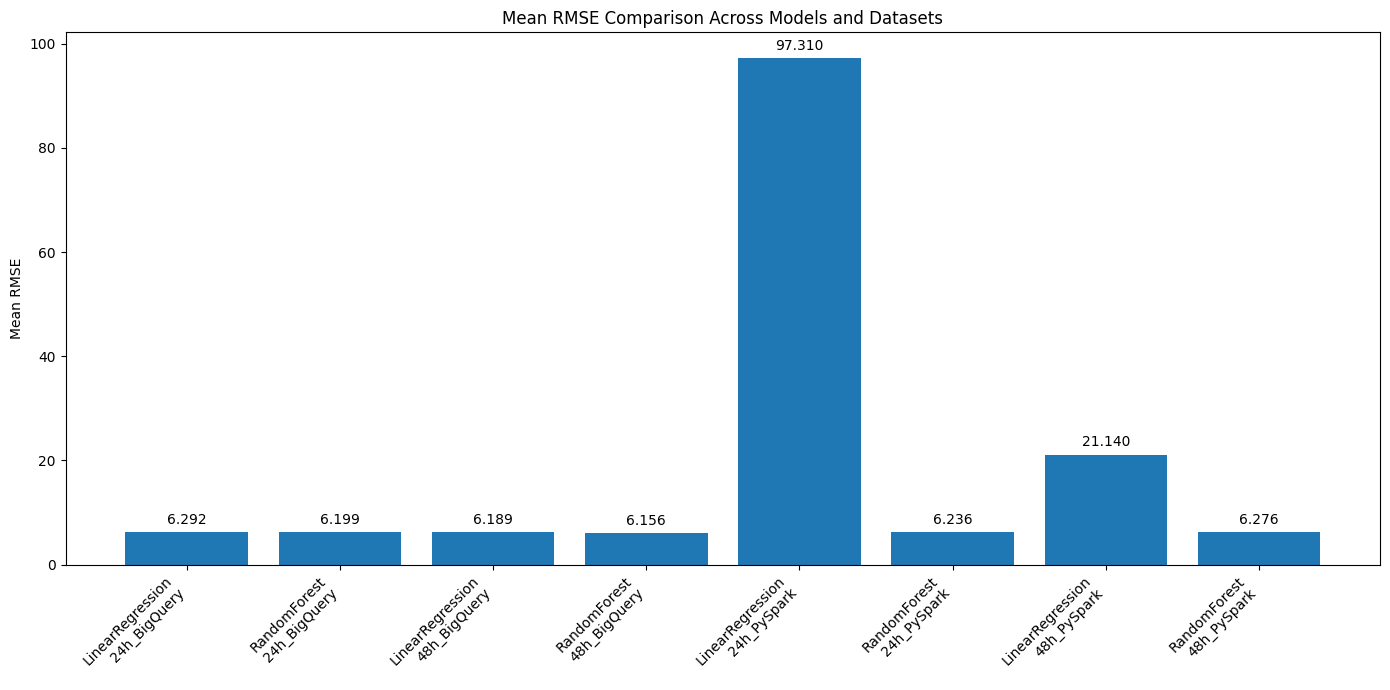

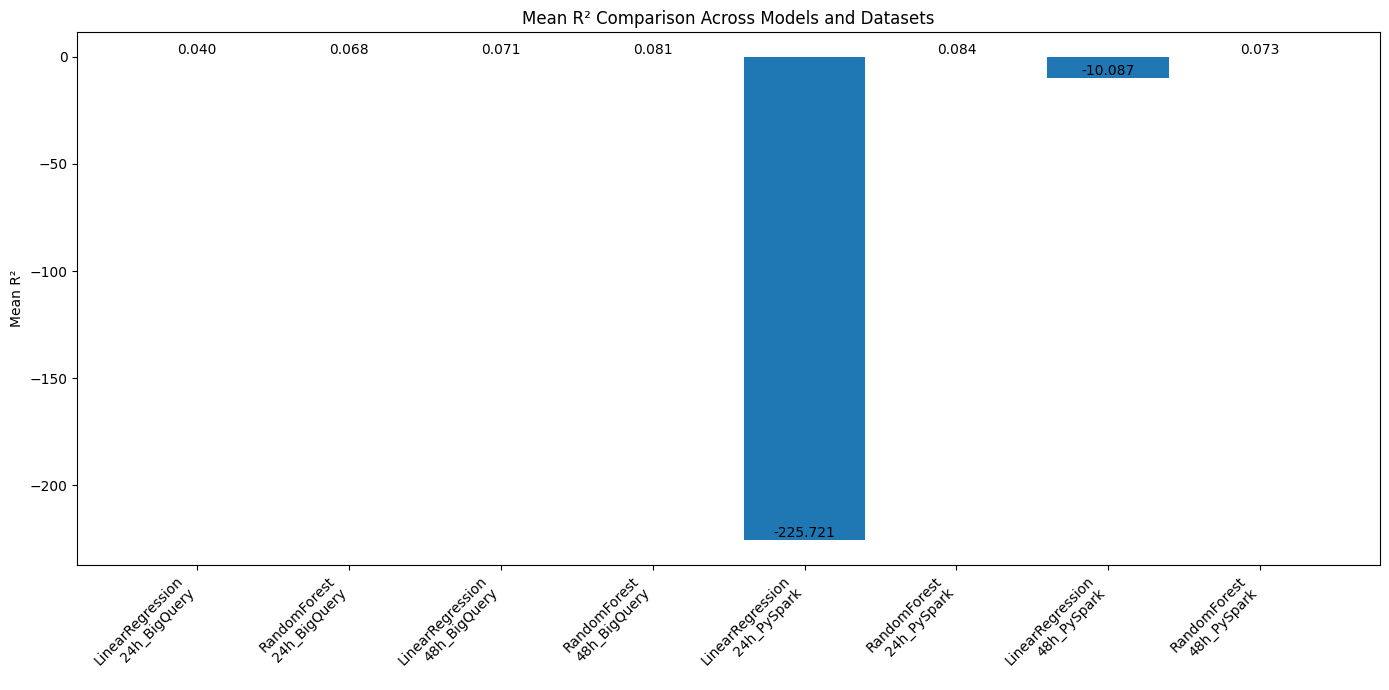

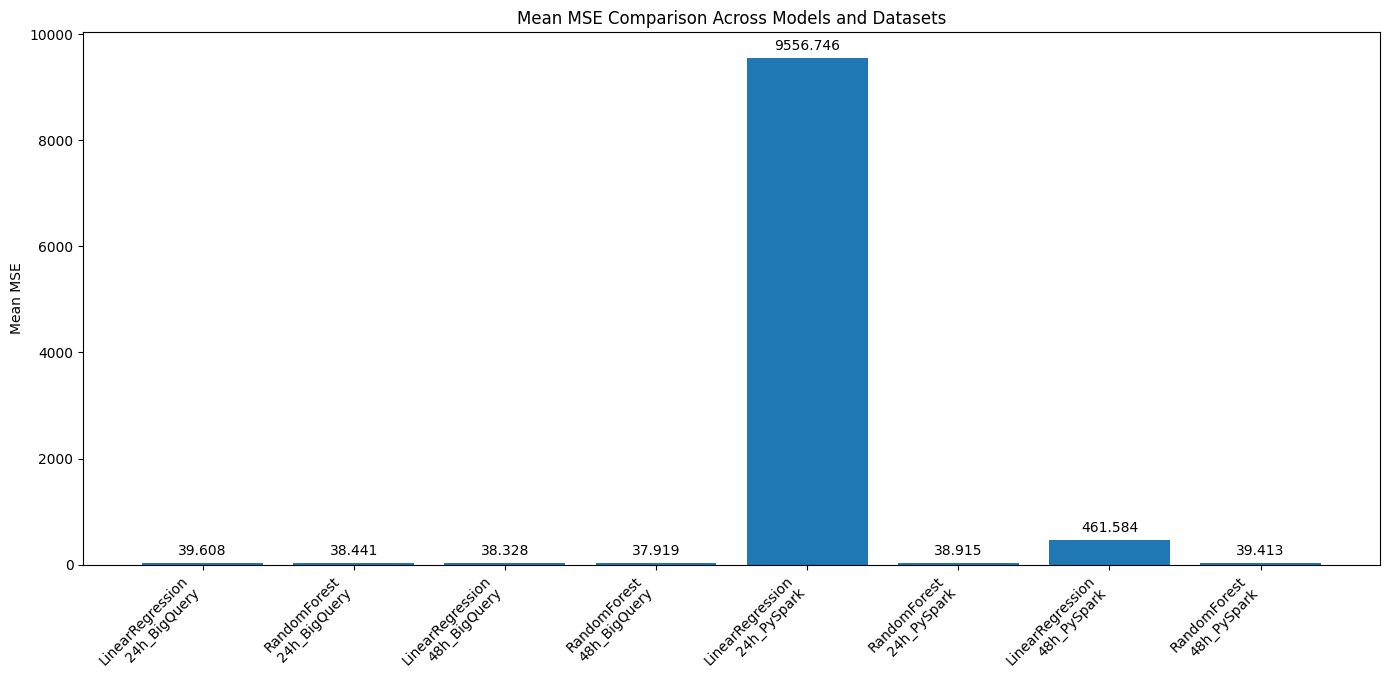

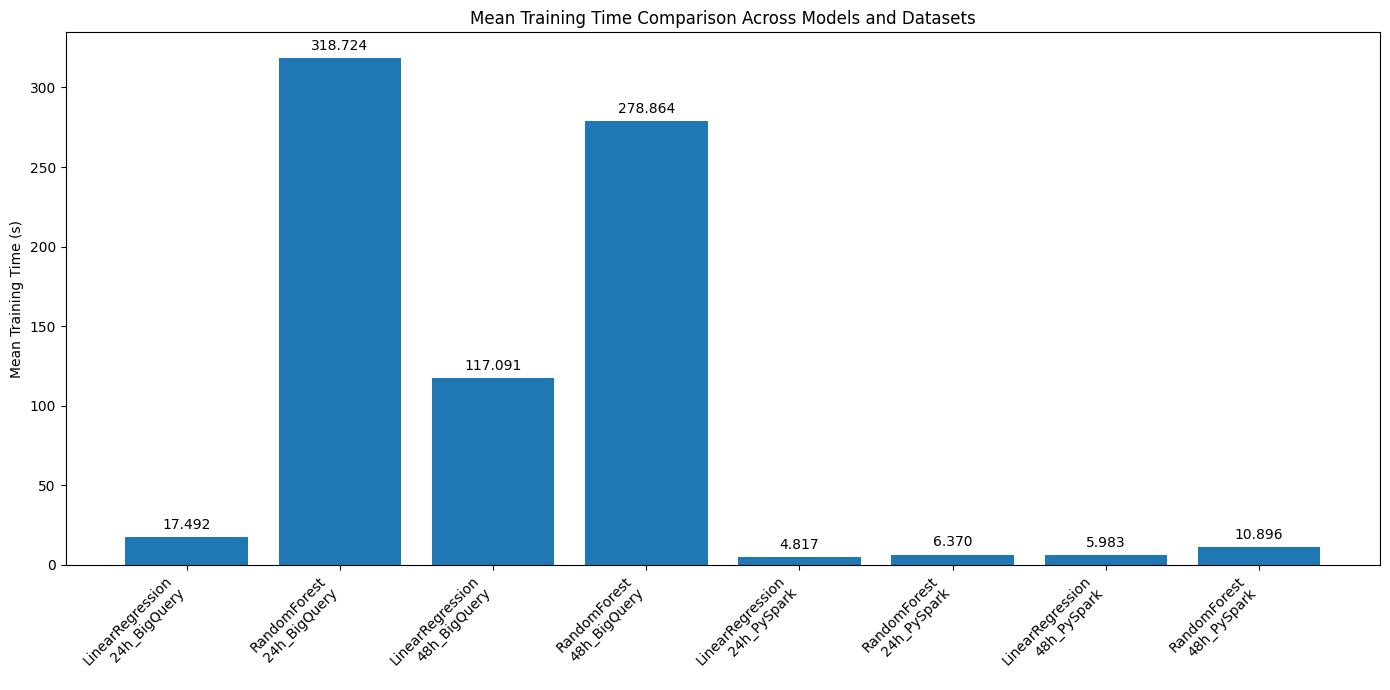

In [ ]:
datasets = ['24h_BigQuery', '48h_BigQuery', '24h_PySpark', '48h_PySpark']
modelos = ['LinearRegression', 'RandomForest']

resultados = {
    '24h_BigQuery': resultados_modelos_24_bq,
    '48h_BigQuery': resultados_modelos_48_bq,
    '24h_PySpark': resultados_modelos_24_pyspark,
    '48h_PySpark': resultados_modelos_48_pyspark,
}

def plot_metric(metric_name, ylabel, title):
    means = []
    for dataset in datasets:
        for modelo in modelos:
            metric_mean = np.mean(resultados[dataset][modelo][metric_name])
            means.append(metric_mean)

    labels = [f"{modelo}\n{ds}" for ds in datasets for modelo in modelos]

    plt.figure(figsize=(14,7))
    bars = plt.bar(labels, means)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Mostrar valores em cima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * max(means), f"{yval:.3f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plots para cada métrica
plot_metric('RMSE', 'Mean RMSE', 'Mean RMSE Comparison Across Models and Datasets')
plot_metric('R2', 'Mean R²', 'Mean R² Comparison Across Models and Datasets')
plot_metric('MSE', 'Mean MSE', 'Mean MSE Comparison Across Models and Datasets')
plot_metric('Tempo', 'Mean Training Time (s)', 'Mean Training Time Comparison Across Models and Datasets')

**Description of Results:**
**1.	RMSE (Root Mean Squared Error) Comparison:**

•	The RMSE values are mostly low (around 6) for BigQuery datasets (both 24h and 48h) across both Linear Regression and Random Forest models.

•	PySpark models, especially the 24h datasets, show a dramatically higher RMSE, with Linear Regression hitting almost 100 and Random Forest around 6, but slightly higher than 
    BigQuery.

•	For the 48h PySpark data, the Linear Regression model has a much higher RMSE (~21) compared to the others, while Random Forest performs closer to BigQuery’s results.

**2.	R² (Coefficient of Determination) Comparison:**

•	BigQuery datasets yield positive R² values between roughly 0.04 and 0.08, indicating modest explanatory power.

•	The PySpark 24h Linear Regression model yields a large negative R² (~ -225), which indicates very poor model performance, possibly worse than just predicting the mean.

•	Other PySpark models show variable R² scores, with some slight negative values indicating some poor fits.

**3.	MSE (Mean Squared Error) Comparison:**

•	The MSE plot shows consistent patterns with RMSE.

•	BigQuery models have low MSE values (~38 to 40).

•	PySpark Linear Regression on 24h data has an extremely high MSE (~9556), reinforcing the poor fit.

•	The 48h PySpark Linear Regression model also shows elevated MSE (~461) compared to others.

•	Random Forest in PySpark performs closer to BigQuery, but still with slightly higher errors.

**4.	Training Time Comparison:**

•	BigQuery models take significantly longer to train, especially the Random Forest models (up to ~320 seconds).

•	PySpark models train much faster (under ~12 seconds in all cases), with Linear Regression generally faster than Random Forest.

•	This highlights a trade-off between training speed and possibly accuracy/stability.

**Conclusion:**


•	BigQuery Models Generally Perform Better in Prediction Accuracy:

Both Linear Regression and Random Forest models trained on BigQuery datasets show more consistent and lower errors (RMSE, MSE) and positive R² values, indicating better fit and predictive power.

•	PySpark Linear Regression on 24h Data Shows Severe Issues:

The very large negative R² and huge error values for the 24h Linear Regression model in PySpark strongly suggest either a problem with data preprocessing, model setup, or an ill-suited model for the data in that environment.

•	Random Forest is More Robust Across Platforms:

Random Forest performs better than Linear Regression in the PySpark environment, suggesting it may better handle data irregularities or noise.

•	Training Time vs Performance Tradeoff:

BigQuery takes longer to train but yields better results. PySpark offers faster training but at the expense of accuracy and model stability in some cases.